# Notebook configuration

In [1]:
run_number    = 4520
save_plots    = False
outputfolder  = "plots/{}/".format(run_number)
corr_filename = "merged_corrections.h5"
inputfilename = "/home/brais/Documents/Next/Na/data/{0}/dst_{0}.root.h5".format(run_number)

Zrange        =    0, 600
XYrange       = -198, 198
Rrange        =    0, max(XYrange)
Prange        = -3.2, 3.2  
Erange_raw    =    0, 2e5
Erange_zcorr  =  5e3, 2e5
Erange_xycorr =  5e3, 2e5
Erange_XR     =  6e3, 12e3
Qrange        =    0, 40e2

S1Erange      =    0, 250
S1Wrange      =    0, 300
S1Hrange      =    0, 400
S2Wrange      =    0, 40
S2Hrange      =    0, 50e3
NSirange      =    0, 30

Zrange_LT     =   50, 350
nX, nY        =   50,  50

# Na analysis

In [2]:
import os
import functools
import time
print("Running on ", time.asctime())

import numpy             as np
import tables            as tb
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf
import invisible_cities.io  .dst_io         as dstio
import invisible_cities.reco.corrections    as corrf

from icaro.core.hst_functions import hist
from icaro.core.hst_functions import hist2d
from icaro.core.hst_functions import pdf
from icaro.core.hst_functions import labels
from icaro.core.hst_functions import hist2d_profile
from icaro.core.hst_functions import covariance
from icaro.core.hst_functions import resolution
from icaro.core.hst_functions import gausstext
from icaro.core.hst_functions import shift_to_bin_centers
from icaro.core.hst_functions import save_to_folder

from copy import copy

pi   = np.pi
save = functools.partial(save_to_folder, outputfolder) if save_plots else lambda *x: None

Running on  Wed Jul 26 16:58:55 2017


#### General plotting options

In [3]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

### Useful functions

In [4]:
two_gauss = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:-1])+args[-1]
one_gauss = lambda x, *args: fitf.gauss(x, *args[:3]) +args[-1]

def plot_map(xy_map, run=""):
    x , y  = xy_map._xs
    x0, y0 = np.min(x) - np.diff(x)[0]/2, np.min(y) - np.diff(y)[0]/2
    x1, y1 = np.max(x) + np.diff(x)[0]/2, np.max(y) + np.diff(y)[0]/2
    f      = xy_map._fs
    u      = xy_map._us
    x, y   = np.repeat(x, y.size), np.tile(y, x.size)

    plt.figure()

    #plt.subplot(1, 2, 1)
    hist2d(x, y, f.shape, ((x0, x1), (y0, y1)), weights=f.flatten(), new_figure=False)
    plt.colorbar().set_label("Correction factor")
    labels("x (mm)", "y (mm)", str(run))
    plt.savefig("merged_map.pdf")
    """
    plt.subplot(1, 2, 2)
    hist2d(x, y, u.shape, ((x0, x1), (y0, y1)), weights=u.flatten(), new_figure=False)
    plt.colorbar().set_label("Correction uncertainty")
    labels("x (mm)", "y (mm)", str(run))
    """
    
def profile_and_scatter(x, y, z, nbin, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    x, y, z, ze = fitf.profileXY(x, y, z, *nbin, *args, **kwargs)
    x_ = np.repeat(x, x.size)
    y_ = np.tile  (y, y.size)
    z_ = z.flatten()
    return (x, y, z, ze), plt.scatter(x_, y_, c=z_, marker="s"), plt.colorbar()

# Read data

In [5]:
full = dstf.load_dst(inputfilename, "DST", "Events")
full = full[full.R<max(Rrange)] # soft radial cut to reduce badly reconstructed events
print(len(full[full.nS2==1])+len(full[full.nS2==2])/2.)
full.head()

42226.0


event          time  peak  nS2    S1w        S1h         S1e       S1t  \
0      1  1.500371e+09     0    1  175.0  25.080278  123.319018  200125.0   
2      3  1.500371e+09     0    1  200.0  15.560621   85.379706  200125.0   
3      4  1.500371e+09     0    1  150.0   9.811378   46.989243  200100.0   
4      5  1.500371e+09     0    1  125.0   7.531867   32.424671  200100.0   
5      6  1.500371e+09     0    1  150.0   9.752417   46.730792  200125.0   

         S2w           S2h    ...           S2t  Nsipm        DT         Z  \
0  25.201250  16910.757812    ...      376112.5    120  175.9875  175.9875   
2  20.776875  15982.678711    ...      350162.5     87  150.0375  150.0375   
3   9.103563  11846.042969    ...      362187.5     49  162.0875  162.0875   
4  20.979375   2610.416504    ...      368337.5     33  168.2375  168.2375   
5  12.138188   7612.934082    ...      420112.5     37  219.9875  219.9875   

            X          Y           R       Phi       Xrms       Yrms  
0   -9.922687  -3.392437   10.486579 -2.812164  22.661728  28.660432  
2 -123.604512   4.272636  123.678336  3.107039  20.367255  21.109760  
3   28.270247 -32.568829   43.126970 -0.855936  20.628129  24.554798  
4 -195.420528  -4.320839  195.468290 -3.119486  12.012299  10.906860  
5  -86.106461 -81.994585  118.900945 -2.380650  12.334432  10.974761  

[5 rows x 22 columns]

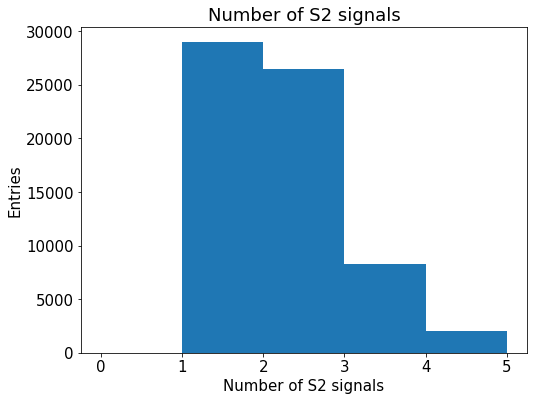

In [6]:
hist(full.nS2, 5, (0, 5))
labels("Number of S2 signals", "Entries", "Number of S2 signals")
save("NS2")

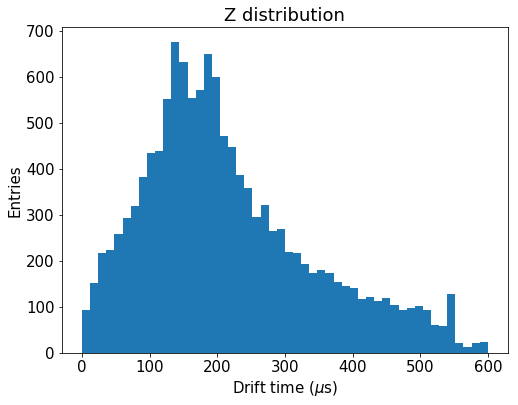

In [7]:
hist(full[full.S2e<10e3].Z, 50, Zrange)
labels("Drift time ($\mu$s)", "Entries", "Z distribution")

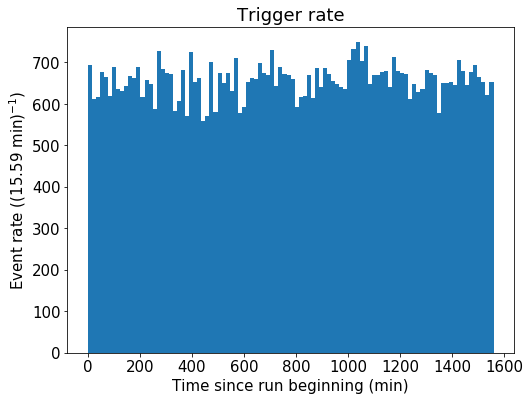

In [8]:
T       = full.time.values / 60
T      -= np.min(T)
 
y, x, _ = hist(T, 100, (np.min(T), np.max(T)))
labels("Time since run beginning (min)",
       "Event rate (({:.2f} min)$^{{-1}}$)".format(np.diff(x)[0]), "Trigger rate")

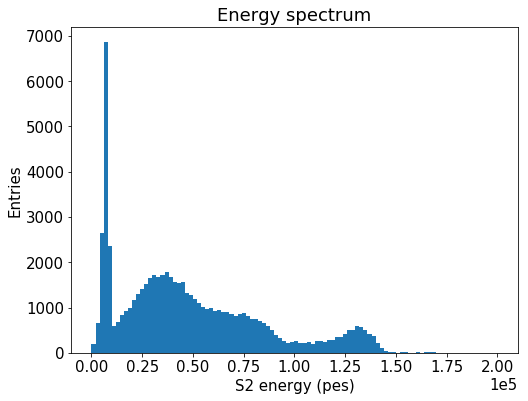

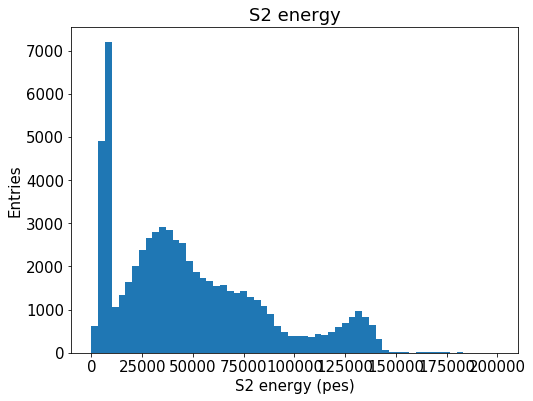

In [9]:
hist(full.S2e, 100, (0, 200e3))
labels("S2 energy (pes)", "Entries", "Energy spectrum")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
hist(full.S2e, 60, Erange_raw)
labels("S2 energy (pes)", "Entries", "S2 energy")

# S1 energy

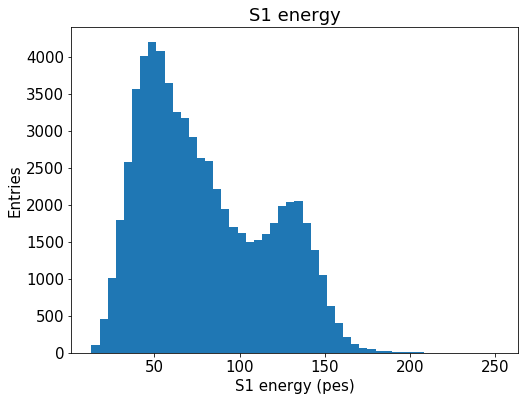

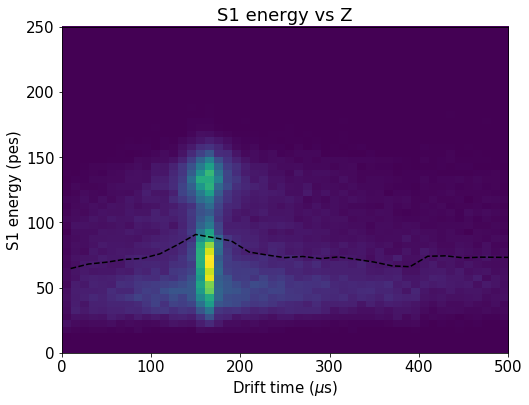

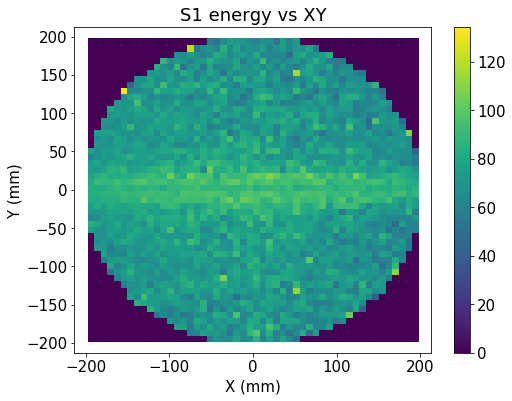

In [10]:
sel_PP = fitf.in_range(full.S2e, 0, 1000e5)

hist(full[sel_PP].S1e, 50)
labels("S1 energy (pes)", "Entries", "S1 energy")
save("S1energy")

hist2d(full[sel_PP].Z, full[sel_PP].S1e, (50, 50), range=([0,500], S1Erange))
x, y, _ = fitf.profileX(full[sel_PP].Z, full[sel_PP].S1e, 30, xrange=Zrange, yrange=S1Erange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 energy (pes)", "S1 energy vs Z")
save("S1energyvsZ")

sel_Z   = fitf.in_range(full.Z, 0, 500)
sel_nS2 = full.nS2=1

sel = sel_Z & sel_nS2 #& sel_E
profile_and_scatter(full[sel_PP].X.values, full[sel_PP].Y.values, full[sel_PP].S1e.values, [50,50]);
labels("X (mm)", "Y (mm)", "S1 energy vs XY")
save("S1energyvsXY")


# S1 width

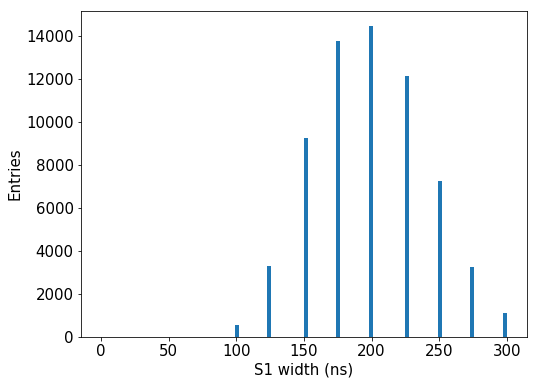

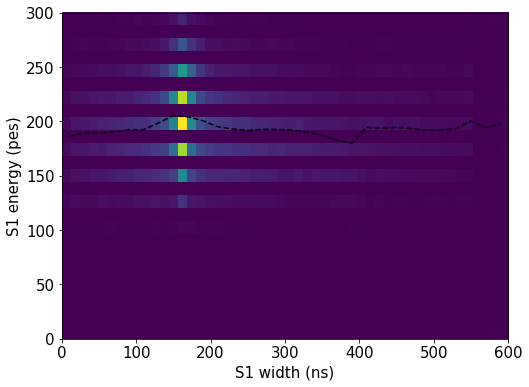

In [11]:
nb = max(S1Wrange)//25
hist(full[sel_PP].S1w, 100, S1Wrange)
labels("S1 width (ns)", "Entries")
save("S1width")

hist2d(full[sel_PP].Z, full[sel_PP].S1w, (50, 25), range=(Zrange, S1Wrange))
x, y, _ = fitf.profileX(full[sel_PP].Z, full[sel_PP].S1w, 30, xrange=Zrange, yrange=S1Wrange)
plt.plot(x, y, profOpt)

labels("S1 width (ns)", "S1 energy (pes)")
save("S1widthvsZ")

# S1 height

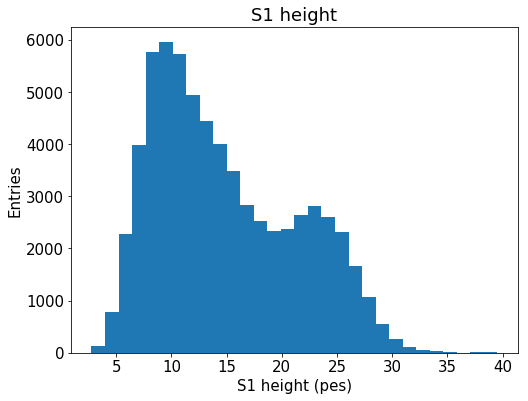

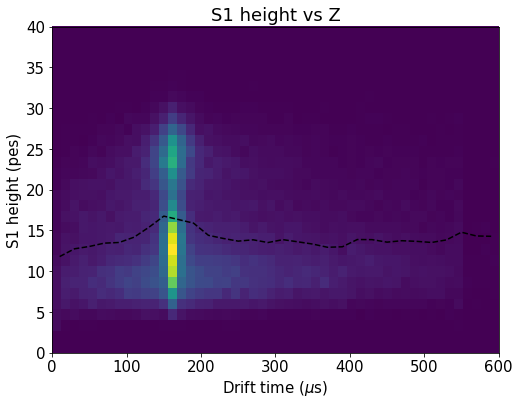

In [12]:
hist(full[sel_PP].S1h, 30)
labels("S1 height (pes)", "Entries", "S1 height")
save("S1height")

hist2d(full[sel_PP].Z, full[sel_PP].S1h, (50, 30), range=(Zrange, [0,40]))
x, y, _ = fitf.profileX(full[sel_PP].Z, full[sel_PP].S1h, 30, xrange=Zrange, yrange=S1Hrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 height (pes)", "S1 height vs Z")
save("S1heightvsZ")

# S1 peak to area ratio

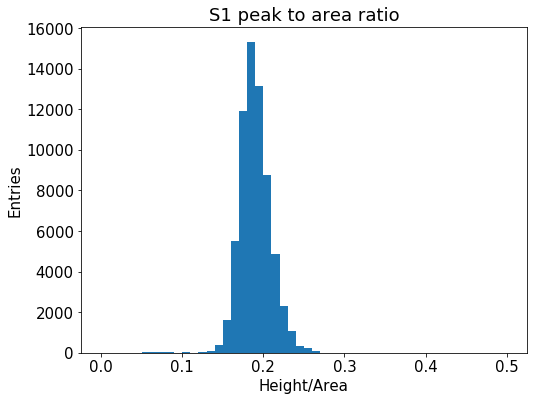

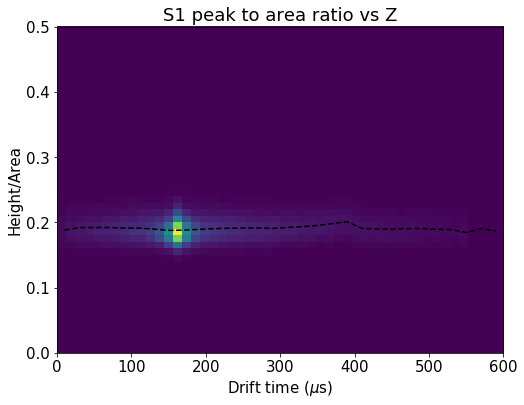

In [13]:
S1r    = full[sel_PP].S1h/full[sel_PP].S1e
_range = 0, 0.5

hist(S1r, 50, range=_range)
labels("Height/Area", "Entries", "S1 peak to area ratio")
save("S1Peak2Area")

hist2d(full[sel_PP].Z, S1r, (50, 50), range=(Zrange, _range))
x, y, _ = fitf.profileX(full[sel_PP].Z, S1r, 30, xrange=Zrange, yrange=_range)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "Height/Area", "S1 peak to area ratio vs Z")
save("S1ratiovsZ")

# S2 energy

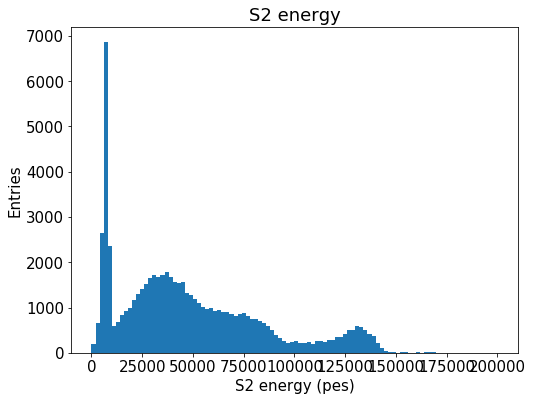

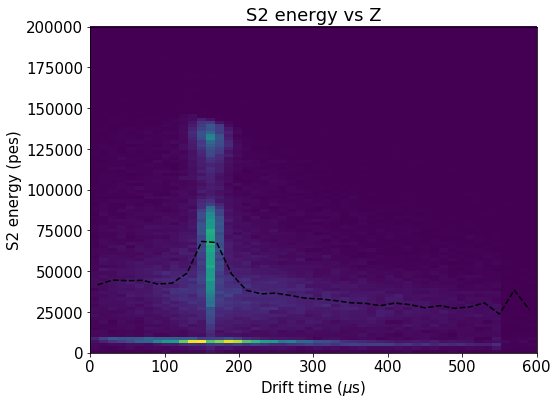

In [14]:
hist(full.S2e, 100, range=Erange_raw)
labels("S2 energy (pes)", "Entries", "S2 energy")
save("S2energy")

hist2d(full.Z, full.S2e, (50, 100), range=(Zrange, Erange_raw))
x, y, _ = fitf.profileX(full.Z, full.S2e, 30, xrange=Zrange, yrange=Erange_raw)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)", "S2 energy vs Z")
save("S2energyvsZ")

# S2 width

NameError: name 'sel_PP_' is not defined

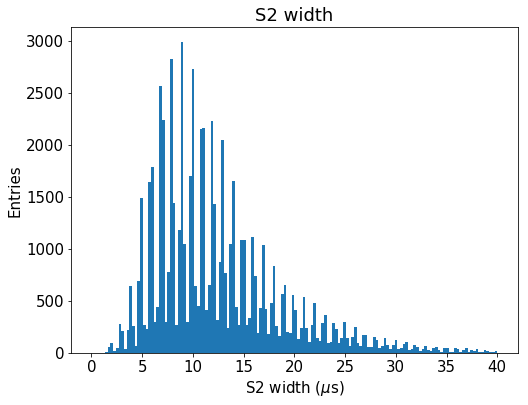

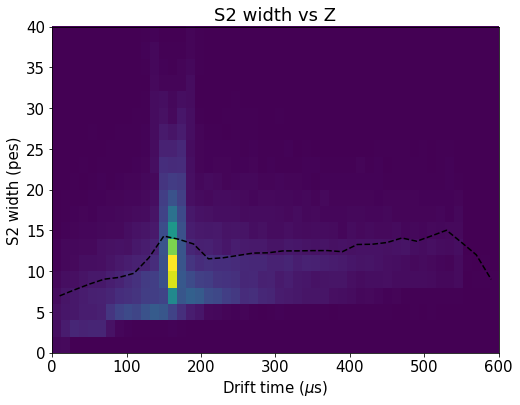

In [15]:
hist(full.S2w, 150, range=S2Wrange)
labels("S2 width ($\mu$s)", "Entries", "S2 width")
save("S2width")

hist2d(full[sel_PP].Z, full[sel_PP].S2w, (50, 20), range=(Zrange, S2Wrange))
x, y, _ = fitf.profileX(full[sel_PP].Z, full[sel_PP].S2w, 30, xrange=Zrange, yrange=S2Wrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 width (pes)", "S2 width vs Z")
save("S2widthvsZ")


E_ = full[sel_PP_].S2e #* Zcorr(full[sel_PP_].Z.values).value * xy_map(full[sel_PP_].X.values,full[sel_PP_].Y.values).value
hist2d(E_ , full[sel_PP_].S2w, (50, 20), range=([1.0e5,1.6e5], [0, 60]),norm=colors.LogNorm())
x, y, _ = fitf.profileX(E_ , full[sel_PP_].S2w, 30, xrange=[1.0e5,1.6e5], yrange=[0, 60])
plt.plot(x, y, profOpt)

labels("S2 charge (pes)", "S2 width (pes)", "S2 width vs S2 charge")
save("S2widthvsS2charge")

# S2 height

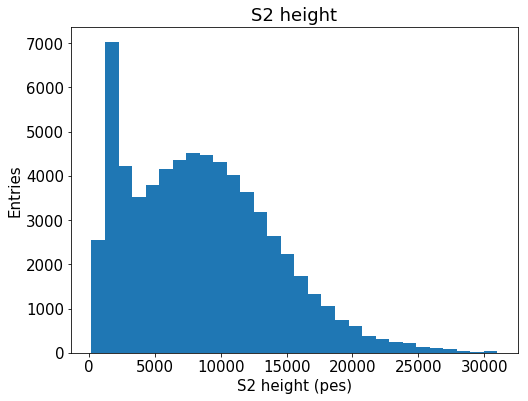

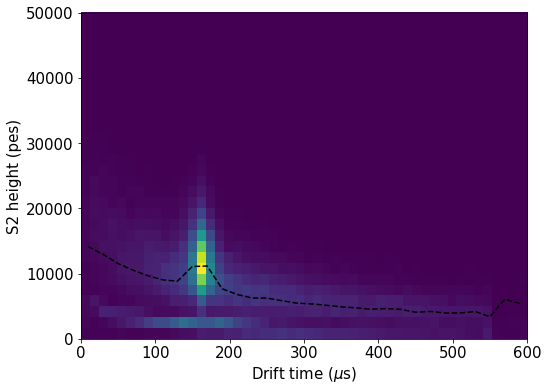

In [16]:
hist(full.S2h, 30)
labels("S2 height (pes)", "Entries", "S2 height")
save("S2height")

hist2d(full[sel_PP].Z, full[sel_PP].S2h, (50, 30), range=(Zrange, S2Hrange))
x, y, _ = fitf.profileX(full[sel_PP].Z, full[sel_PP].S2h, 30, xrange=Zrange, yrange=S2Hrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 height (pes)")
save("S2heightvsZ")

# S2 peak to area ratio

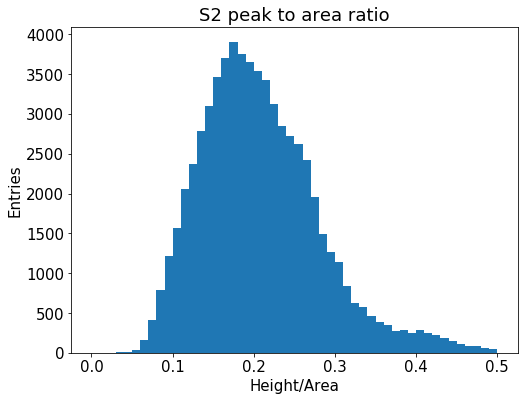

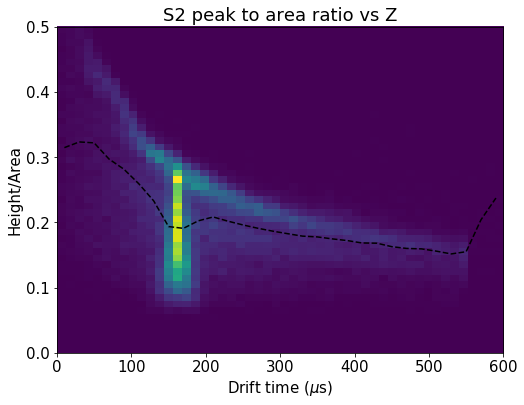

In [17]:
_range = 0, 0.5

S2r = full[sel_PP].S2h/full[sel_PP].S2e

hist(S2r, 50, range=_range)
labels("Height/Area", "Entries", "S2 peak to area ratio")
save("S2Peak2Area")

hist2d(full[sel_PP].Z, S2r, (50, 50), range=(Zrange, _range))
x, y, _ = fitf.profileX(full[sel_PP].Z, S2r, 30, xrange=Zrange, yrange=_range)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "Height/Area", "S2 peak to area ratio vs Z")
save("S2ratiovsZ")

# S2 vs S1

'\nsel = coref.in_range(full.S1e, *S1Erange) & coref.in_range(full.S2e, *Erange_raw)\nc = covariance(full[sel].S1e, full[sel].S2e)\nprint(*c)\nlabels("S1 energy (pes)", "S2 energy (pes)")\nsave("S2vsS1")\n'

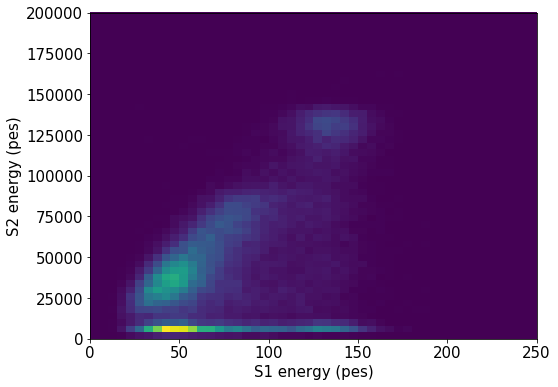

In [18]:
Energy = full.S2e#*Zcorr(full.Z.values).value* xy_map(data.X.values,data.Y.values).value
sel_PP  = Energy>0.125000

hist2d(full[sel_PP].S1e, full[sel_PP].S2e, (50, 50), range=(S1Erange, Erange_raw))
labels("S1 energy (pes)", "S2 energy (pes)")
save("S2vsS1")
#x, y, _ = fitf.profileX(full.S1e, full.S2e, 30, xrange=S1Erange, yrange=Erange_raw)
#plt.plot(x, y, profOpt)
"""
sel = coref.in_range(full.S1e, *S1Erange) & coref.in_range(full.S2e, *Erange_raw)
c = covariance(full[sel].S1e, full[sel].S2e)
print(*c)
labels("S1 energy (pes)", "S2 energy (pes)")
save("S2vsS1")
"""

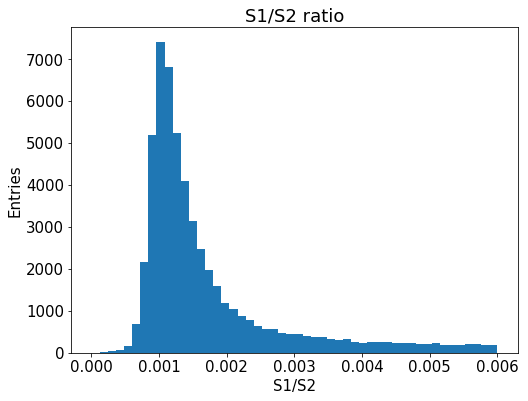

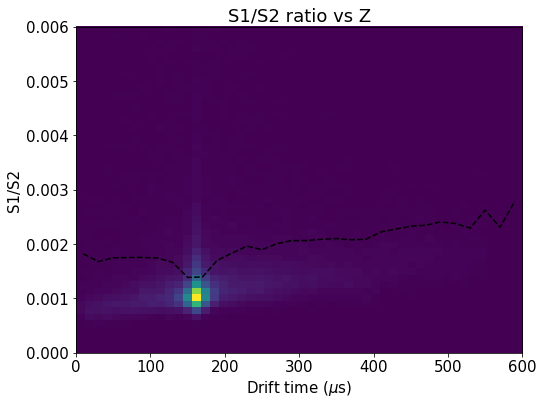

In [19]:
_range = 0, 0.006

S12r = full.S1e/full.S2e

hist(S12r, 50, range=_range)
labels("S1/S2", "Entries", "S1/S2 ratio")
save("S12ratio")

hist2d(full.Z, S12r, (50, 50), range=(Zrange, _range))
x, y, _ = fitf.profileX(full.Z, S12r, 30, xrange=Zrange, yrange=_range)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1/S2", "S1/S2 ratio vs Z")
save("S12ratiovsZ")

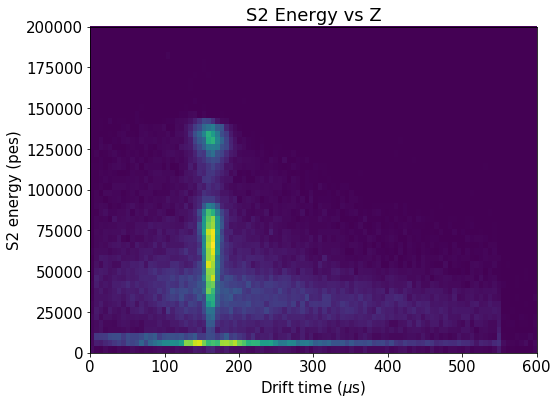

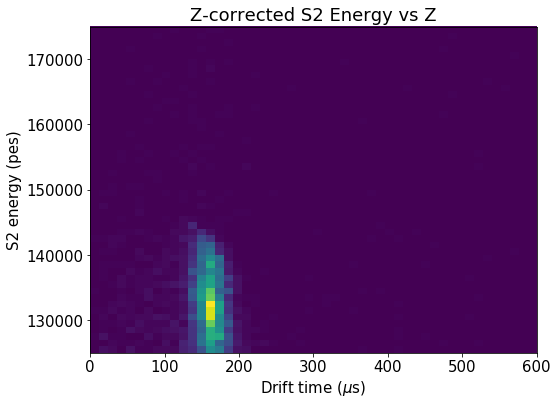

In [20]:
data = full
hist2d(data.Z, data.S2e, (100, 50), range=(Zrange, [0,2e5]))
x, y, u_y = fitf.profileX(data.Z, data.S2e, 25, xrange=(50,550), yrange=[0,12e3])


labels("Drift time ($\mu$s)", "S2 energy (pes)", "S2 Energy vs Z")
save("S2energyvsZ_fiducial")

data = full
hist2d(data.Z, data.S2e, (50, 50), range=(Zrange, [1.25e5,1.75e5]))
x, y, u_y = fitf.profileX(data.Z, data.S2e, 25, xrange=(50,550), yrange=[0,12e3])


labels("Drift time ($\mu$s)", "S2 energy (pes)", "Z-corrected S2 Energy vs Z")
save("S2energyvsZ_fiducial")

# Lifetime calculation

In [21]:
fid = full
fid = fid[(fid.R < 100)] # Fiducialize in order to reduce geometrical effects
print("Ratio:", len(fid)/len(full))
fid.head()

Ratio: 0.3225207680370021


event          time  peak  nS2    S1w        S1h         S1e       S1t  \
0       1  1.500371e+09     0    1  175.0  25.080278  123.319018  200125.0   
3       4  1.500371e+09     0    1  150.0   9.811378   46.989243  200100.0   
6       7  1.500371e+09     0    1  175.0   7.341968   43.901282  200150.0   
11     10  1.500371e+09     0    1  275.0  24.501719  139.344720  200100.0   
12     11  1.500371e+09     0    1  200.0  19.836926  100.596031  200100.0   

          S2w           S2h    ...           S2t  Nsipm        DT         Z  \
0   25.201250  16910.757812    ...      376112.5    120  175.9875  175.9875   
3    9.103563  11846.042969    ...      362187.5     49  162.0875  162.0875   
6    8.600000  11427.326172    ...      359787.5     33  159.6375  159.6375   
11  24.819844  11217.376953    ...      361062.5     93  160.9625  160.9625   
12  23.017500  11519.499023    ...      353637.5     90  153.5375  153.5375   

            X          Y          R       Phi       Xrms       Yrms  
0   -9.922687  -3.392437  10.486579 -2.812164  22.661728  28.660432  
3   28.270247 -32.568829  43.126970 -0.855936  20.628129  24.554798  
6  -49.932229   1.097235  49.944284  3.119622  10.891991  10.950608  
11 -45.506359   3.502096  45.640918  3.064786  19.141062  22.470709  
12 -42.141197  -2.644207  42.224072 -3.078928  21.217653  21.410031  

[5 rows x 22 columns]

# S2 energy fiducialized

Energy at z=0 = 9059.1 +- 53.6
Lifetime      = 1039.2 +- 30.6
Chi2          = 2.36          


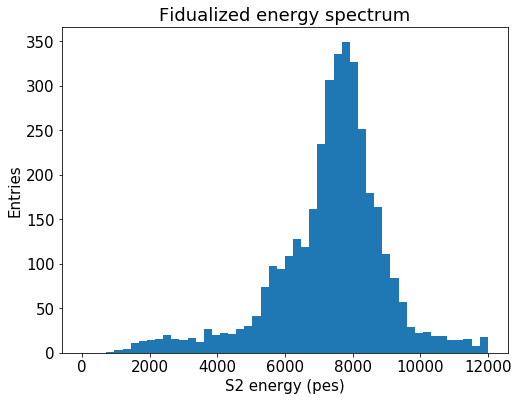

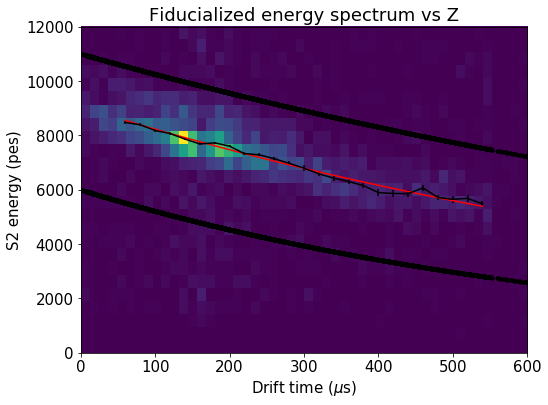

In [22]:
data = fid
hist(data.S2e, 50, range=[0,12e3])
labels("S2 energy (pes)", "Entries", "Fidualized energy spectrum")
save("S2energy_fiducial")

low_cut   =  6000 * np.exp(-0.0014*data.Z.values)
high_cut  = 11000 * np.exp(-0.0007*data.Z.values)
sel       = coref.in_range(data.S2e.values, low_cut, high_cut) # remove low and high E background

hist2d(data.Z, data.S2e, (50, 25), range=(Zrange, [0,12e3]))
x, y, u_y = fitf.profileX(data.Z[sel], data.S2e[sel], 25, xrange=(50,550), yrange=[0,12e3])

plt.errorbar(x, y, yerr=u_y, fmt='k')#, profOpt)
plt.plot(data.Z.values,  low_cut, "k.")
plt.plot(data.Z.values, high_cut, "k.")

seed = 9000,-981#np.max(y), (x[15] - x[5])/np.log(y[15]/y[5])
f    = fitf.fit(fitf.expo, x, y, seed, fit_range=(50,500), sigma=u_y)

plt.plot(x, f.fn(x), fitOpt)
print("Energy at z=0 = {:.1f} +- {:.1f}".format( f.values[0], f.errors[0]))
print("Lifetime      = {:.1f} +- {:.1f}".format(-f.values[1], f.errors[1]))
print("Chi2          = {:.2f}          ".format(f.chi2))

labels("Drift time ($\mu$s)", "S2 energy (pes)", "Fiducialized energy spectrum vs Z")
save("S2energyvsZ_fiducial")

Zcorr = corrf.LifetimeCorrection(-f.values[1], f.errors[1])

# Correction by attachment

[  4.07827724e+05   8.95124377e+03   3.70426306e+02   1.00000000e+04
   1.02117931e+04   1.45606515e+02   9.93779604e+01]
[  4.85985867e+04   2.55317601e+01   3.46759430e+01   2.20726696e+04
   3.16119308e+02   2.37506517e+02   2.25119425e+01]


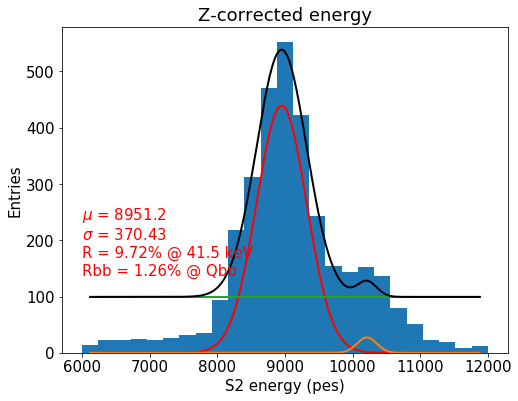

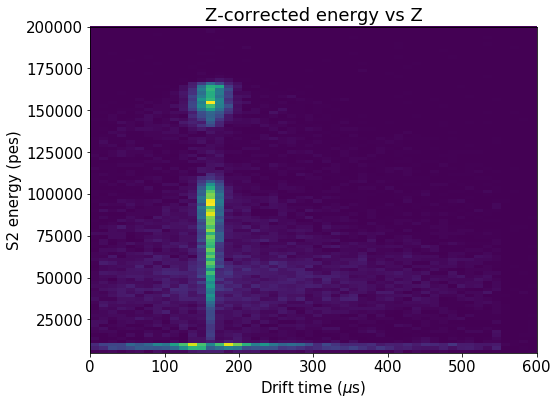

In [23]:
Efid_zcorr = fid.S2e.values * Zcorr(fid.Z.values).value

y, x, _ = hist(Efid_zcorr, 25, range=Erange_XR)

seed = 1e4,  9000, 300, 1e3, 10500, 500, 10
low  =  10,  6000,  50, 1e2,  9000,  50, 0 
upp  = 1e8, 10000, 900, 1e4, 11000, 700, 100
f    = fitf.fit(two_gauss, x, y, seed, fit_range=(8e3,11e3), bounds=(low, upp))
print(f.values)
print(f.errors)


xrange = np.linspace(x[0], x[-1],1000)


plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=2)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)
plt.text(Erange_zcorr[0]+1e3, 1*max(y)/4, gausstext(f.values, 41.5), color=fitOpt)

labels("S2 energy (pes)", "Entries", "Z-corrected energy")
save("S2energyCorr_fiducial")

hist2d(fid.Z.values, Efid_zcorr, (50, 100), range=(Zrange, Erange_zcorr))
labels("Drift time ($\mu$s)", "S2 energy (pes)", "Z-corrected energy vs Z")
save("S2energyCorrvsZ_fiducial")

(array([   37.,    83.,   108.,   139.,   191.,   780.,  3143.,  1757.,
          254.,   157.,   136.,    95.,    77.,    44.,    56.,    36.,
           25.,    32.,    19.,    18.,    17.,    23.,    18.,     7.,
            5.]),
 array([  12.,   36.,   60.,   84.,  108.,  132.,  156.,  180.,  204.,
         228.,  252.,  276.,  300.,  324.,  348.,  372.,  396.,  420.,
         444.,  468.,  492.,  516.,  540.,  564.,  588.]),
 <a list of 25 Patch objects>)

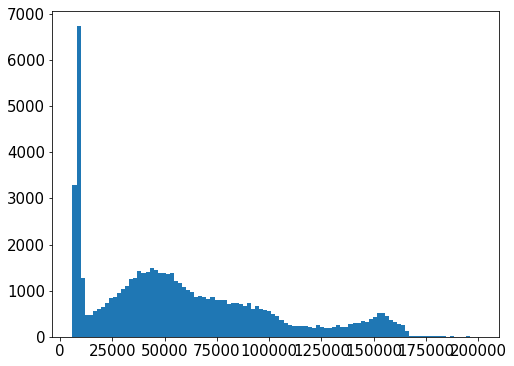

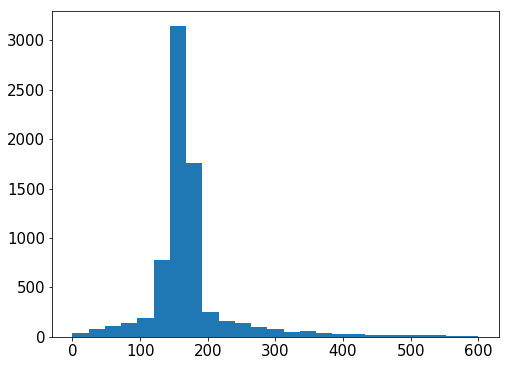

In [24]:
E_zcorr = full.S2e.values * Zcorr(full.Z.values).value

SelE = coref.in_range(E_zcorr,1.2e5,1.75e5)

y, x, _ = hist(E_zcorr, 100, range=[6e3, 2e5]);


hist(full.Z[SelE],25, range=(0,600))




# Tracking

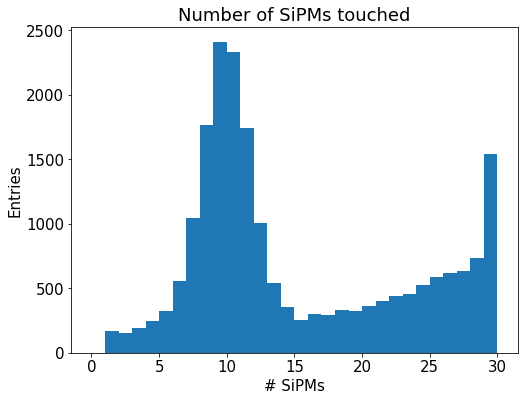

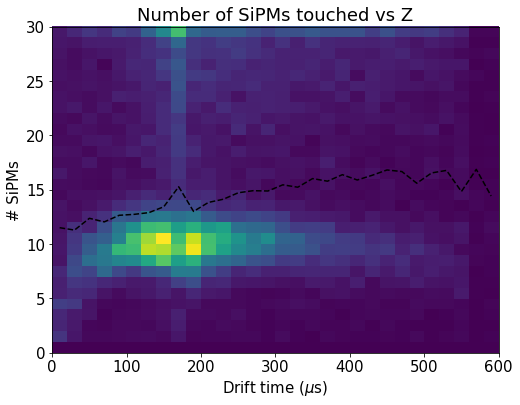

In [25]:
hist(full.Nsipm, max(NSirange), NSirange)
labels("# SiPMs", "Entries", "Number of SiPMs touched")
save("Nsipm")

hist2d(full.Z, full.Nsipm, (30, max(NSirange)), range=(Zrange, NSirange))
x, y, _ = fitf.profileX(full.Z, full.Nsipm, 30, xrange=Zrange, yrange=NSirange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "# SiPMs", "Number of SiPMs touched vs Z")
save("NsipmvsZ")


# Na distribution

In [26]:
E_zcorr = full.S2e.values #* Zcorr(full.Z.values).value
sel     = coref.in_range(E_zcorr, 0, 1.75e6)
sel     = sel & coref.in_range(full.Z, 0     , 900   )
Kr      = full   [sel]
E_zcorr = E_zcorr[sel]

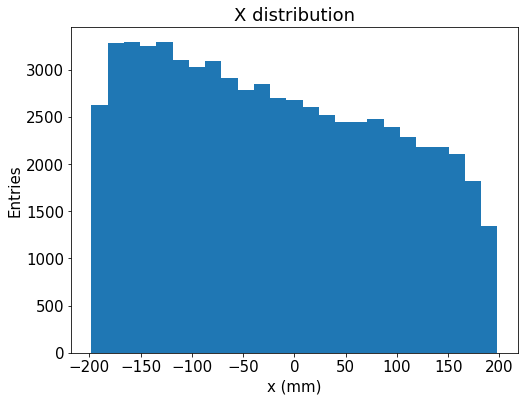

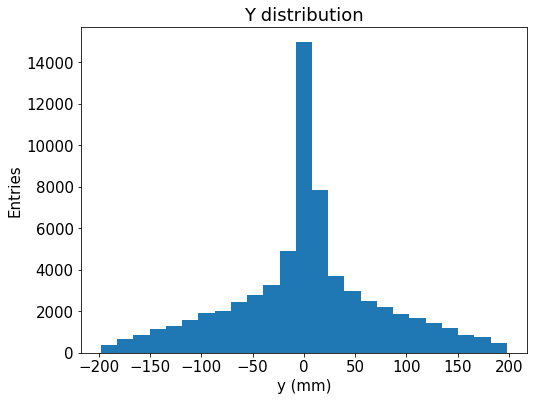

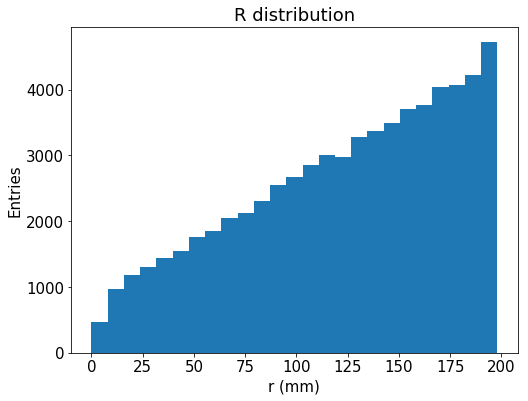

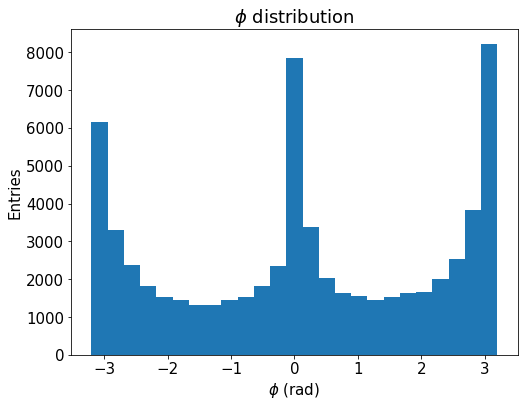

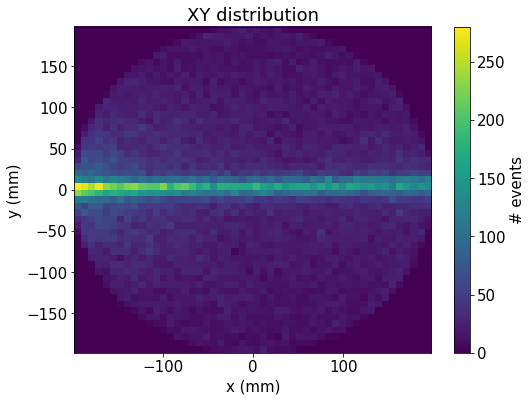

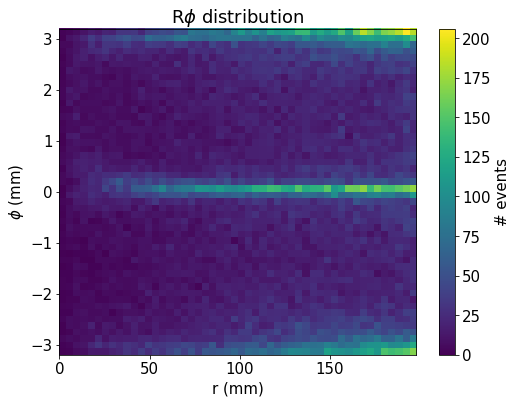

In [27]:
hist(Kr.X, 25, range=XYrange)
labels("x (mm)", "Entries", "X distribution")
save("X")

hist(Kr.Y, 25, range=XYrange)
labels("y (mm)", "Entries", "Y distribution")
save("Y")

hist(Kr.R, 25, range=Rrange)
labels("r (mm)", "Entries", "R distribution")
save("R")

hist(Kr.Phi, 25, range=Prange)
labels("$\phi$ (rad)", "Entries", "$\phi$ distribution")
save("Phi")

nXY, xs, ys, _ = \
hist2d(Kr.X, Kr.Y, (nX, nY), range=(XYrange, XYrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)", "XY distribution")
save("XY")

hist2d(Kr.R, Kr.Phi, (nX, nY), range=(Rrange, Prange))
plt.colorbar().set_label("# events")
labels("r (mm)", "$\phi$ (mm)", "R$\phi$ distribution")
save("RPhi")

# Tracking charge

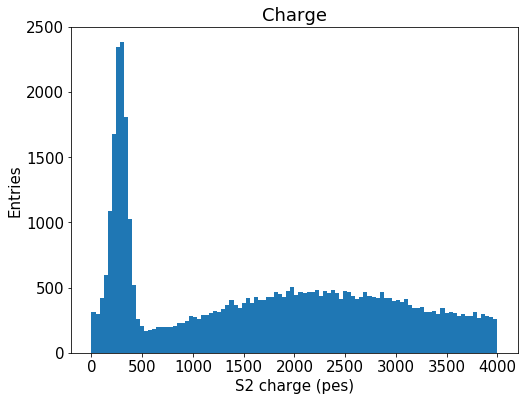

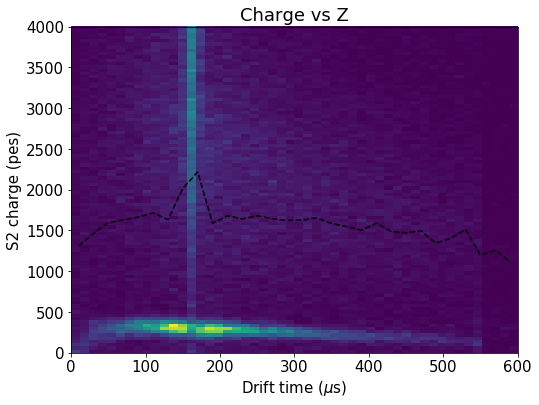

In [28]:
hist(Kr.S2q, 100, range=Qrange)
labels("S2 charge (pes)", "Entries", "Charge")
save("S2charge")

hist2d(Kr.Z, Kr.S2q, (50, 100), range=(Zrange, Qrange))
x, y, _ = fitf.profileX(Kr.Z, Kr.S2q, 30, xrange=Zrange, yrange=Qrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 charge (pes)", "Charge vs Z")
save("S2chargevsZ")

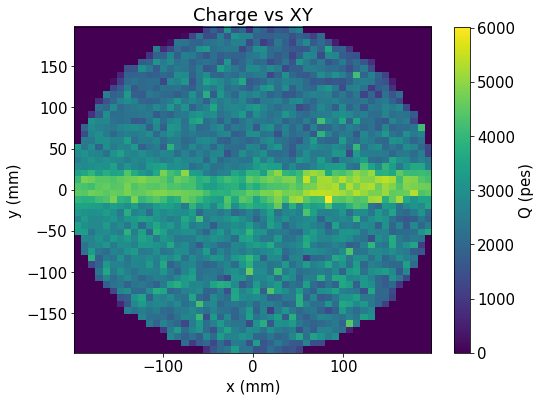

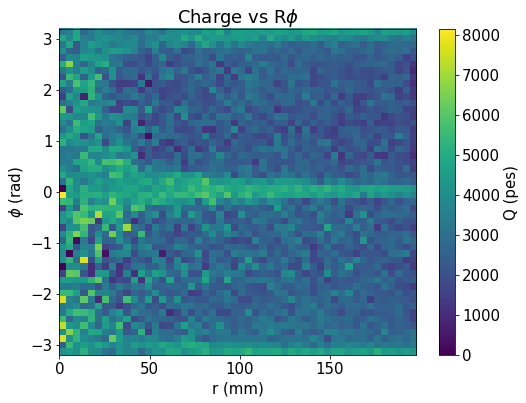

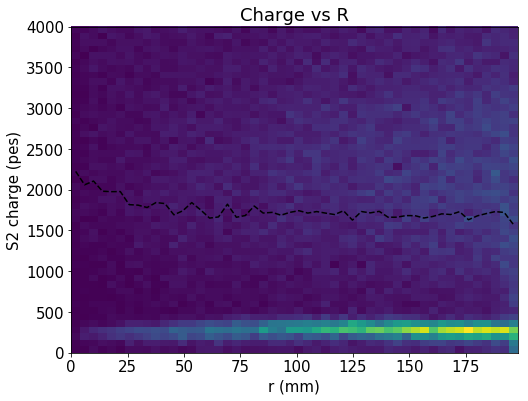

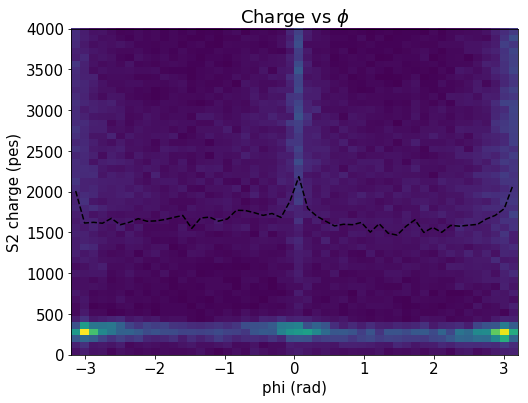

In [29]:
_, _, cb = hist2d_profile(Kr.X, Kr.Y, Kr.S2q, nX, nY, XYrange, XYrange)
cb.set_label("Q (pes)")
labels("x (mm)", "y (mm)", "Charge vs XY")
save("QvsXY")

_, _, cb = hist2d_profile(Kr.R, Kr.Phi, full.S2q, nX, nY, Rrange, Prange)
cb.set_label("Q (pes)")
labels("r (mm)", "$\phi$ (rad)", "Charge vs R$\phi$")
save("QvsRPhi")

hist2d(Kr.R, Kr.S2q, (50, 50), (Rrange, Qrange))
x, y, _ = fitf.profileX(Kr.R, Kr.S2q, 50, xrange=Rrange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 charge (pes)", "Charge vs R")
save("QvsR")

hist2d(Kr.Phi, Kr.S2q, (50, 50), range=(Prange, Qrange))
x, y, _ = fitf.profileX(Kr.Phi, Kr.S2q, 50, xrange=Prange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 charge (pes)", "Charge vs $\phi$")
save("QvsPhi")

# Energy vs position

In [30]:
xy_map = dstf.load_xy_corrections(corr_filename)

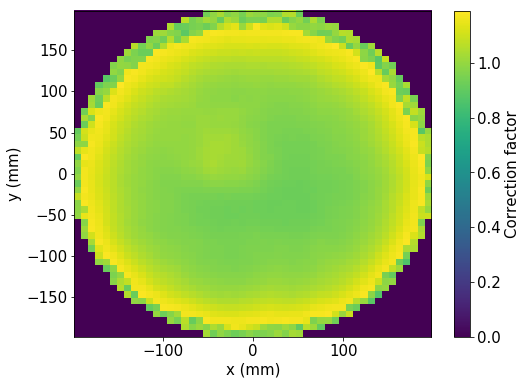

In [31]:
plot_map(xy_map)

[  7.76343178e+05   8.58807234e+03   2.65151597e+02   1.00000000e+05
   9.77822884e+03   1.90335391e+02   7.53785864e+01]
[  2.89497585e+04   8.76038953e+00   9.62959095e+00   2.31691274e+04
   4.13380783e+01   4.45003571e+01   1.38680500e+01]


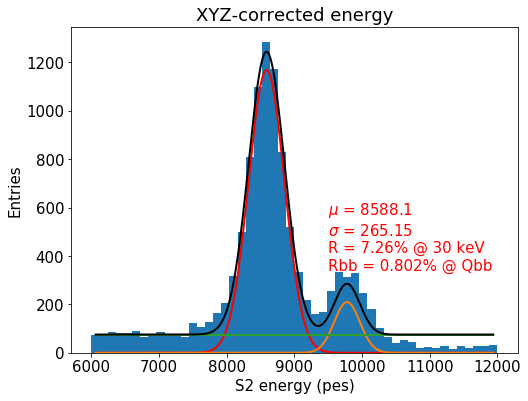

In [32]:
data = full
Efull_zcorr = data.S2e.values * Zcorr(data.Z.values).value * xy_map(data.X.values,data.Y.values).value
y, x, _ = hist(Efull_zcorr, 50, range=[6e3, 12e3])

seed = 1e4,  9000, 300, 1e3, 10000, 500, 10
low  =  10,  8000,  50, 1e2,  9000,  50, 0 
upp  = 1e8, 10000, 900, 1e5, 11000, 500, 100
f    = fitf.fit(two_gauss, x, y, seed, fit_range=(7.9e3,12e3), bounds=(low, upp))
print(f.values)
print(f.errors)


xrange = np.linspace(x[0], x[-1],1000)


plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=2)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)
plt.text(Erange_zcorr[0]+4.5e3, 1*max(y)/4+20, gausstext(f.values, 30), color=fitOpt)

labels("S2 energy (pes)", "Entries", "XYZ-corrected energy")
save("S2energyCorr")

[  3.24713928e+05   8.61041378e+03   2.54608716e+02   8.70759981e+04
   9.80516740e+03   2.94859283e+02   1.31248123e+01]
[  5.24051163e+03   3.80432978e+00   4.12127824e+00   5.83782672e+03
   1.76266770e+01   1.94678502e+01   2.58049479e+00]


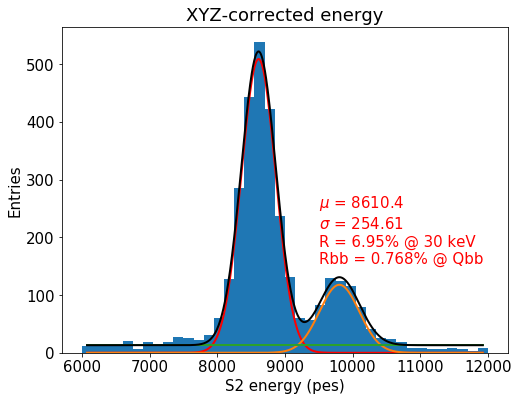

In [33]:
data = fid
Efid_zcorr = data.S2e.values * Zcorr(data.Z.values).value*xy_map(data.X.values,data.Y.values).value

y, x, _ = hist(Efid_zcorr, 40, range=[6e3, 12e3])

seed = 1e4,  9000, 300, 1e3, 10000, 500, 10
low  =  10,  6000,  50, 1e2,  9000,  50, 0 
upp  = 1e8, 10000, 900, 1e5, 11000, 500, 100
f    = fitf.fit(two_gauss, x, y, seed, fit_range=(7.5e3,12e3), bounds=(low, upp))
print(f.values)
print(f.errors)


xrange = np.linspace(x[0], x[-1],1000)


plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=2)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)
plt.text(Erange_zcorr[0]+4.5e3, 1*max(y)/4+20, gausstext(f.values, 30), color=fitOpt)

labels("S2 energy (pes)", "Entries", "XYZ-corrected energy")
save("S2energyCorr")

[  3.18110678e+06   1.52930012e+05   1.86117864e+03   1.00000000e+01]
[  2.78338341e+05   1.46543978e+02   1.61560808e+02   1.76250612e+01]


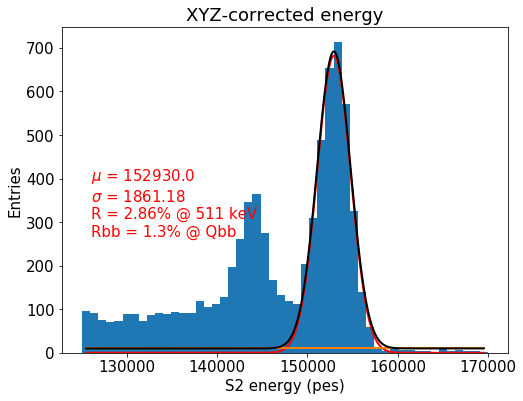

In [34]:
data = full
Efid_zcorr = data.S2e.values * Zcorr(data.Z.values).value * xy_map(data.X.values,data.Y.values).value
y, x, _ = hist(Efid_zcorr, 50, range=[1.25e5,1.7e5])

seed =  1e4,   1.5e5, 1e3, 10
low  =  1e4,  1.45e5,  10E2, 0 
upp  =  1e8,     2e5, 5e5, 10
f    = fitf.fit(one_gauss, x, y, seed, fit_range=(1.45e5,1.75e5), bounds=(low, upp))
print(f.values)
print(f.errors)


xrange = np.linspace(x[0], x[-1],1000)


plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
#plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=2)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)
plt.text(1.25e5+1e3, 1*max(y)/3+30, gausstext(f.values, 511), color=fitOpt)

labels("S2 energy (pes)", "Entries", "XYZ-corrected energy")
save("S2energyCorr")

In [35]:
np.sum(y[(x>148000)&(x<160000)])

3602.0

In [50]:
data        = full
Efull_zcorr = data.S2e.values * Zcorr(data.Z.values).value * xy_map(data.X.values,data.Y.values).value

sel_PP_     = fitf.in_range(Efull_zcorr, 149000, 160000)

[  1.71251023e+06   1.53400856e+05   1.65287687e+03   1.00000000e+01]
[  7.54705339e+04   4.64540430e+01   6.15309708e+01   7.17167318e+00]


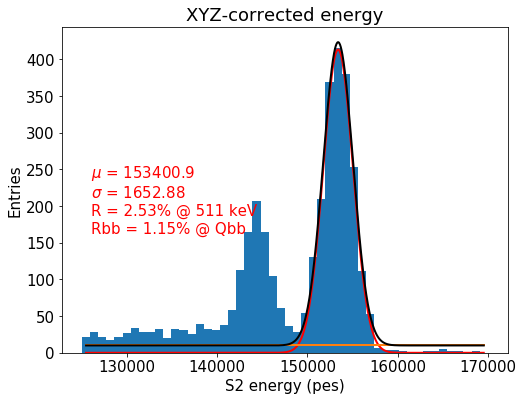

In [103]:
data = fid
Efid_zcorr = data.S2e.values * Zcorr(data.Z.values).value *xy_map(data.X.values,data.Y.values).value
y, x, _ = hist(Efid_zcorr, 50, range=[1.25e5,1.7e5])

seed =  1e4,   1.5e5, 1e3, 10
low  =  1e4,  1.45e5,  10e2, 0 
upp  =  1e8,     2e5, 5e5, 10
f    = fitf.fit(one_gauss, x, y, seed, fit_range=(1.475e5,1.6e5), bounds=(low, upp))
print(f.values)
print(f.errors)


xrange = np.linspace(x[0], x[-1],1000)


plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
#plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=2)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)
plt.text(1.25e5+1e3, 1*max(y)/3+25, gausstext(f.values, 511), color=fitOpt)

labels("S2 energy (pes)", "Entries", "XYZ-corrected energy")
save("S2energyCorr")

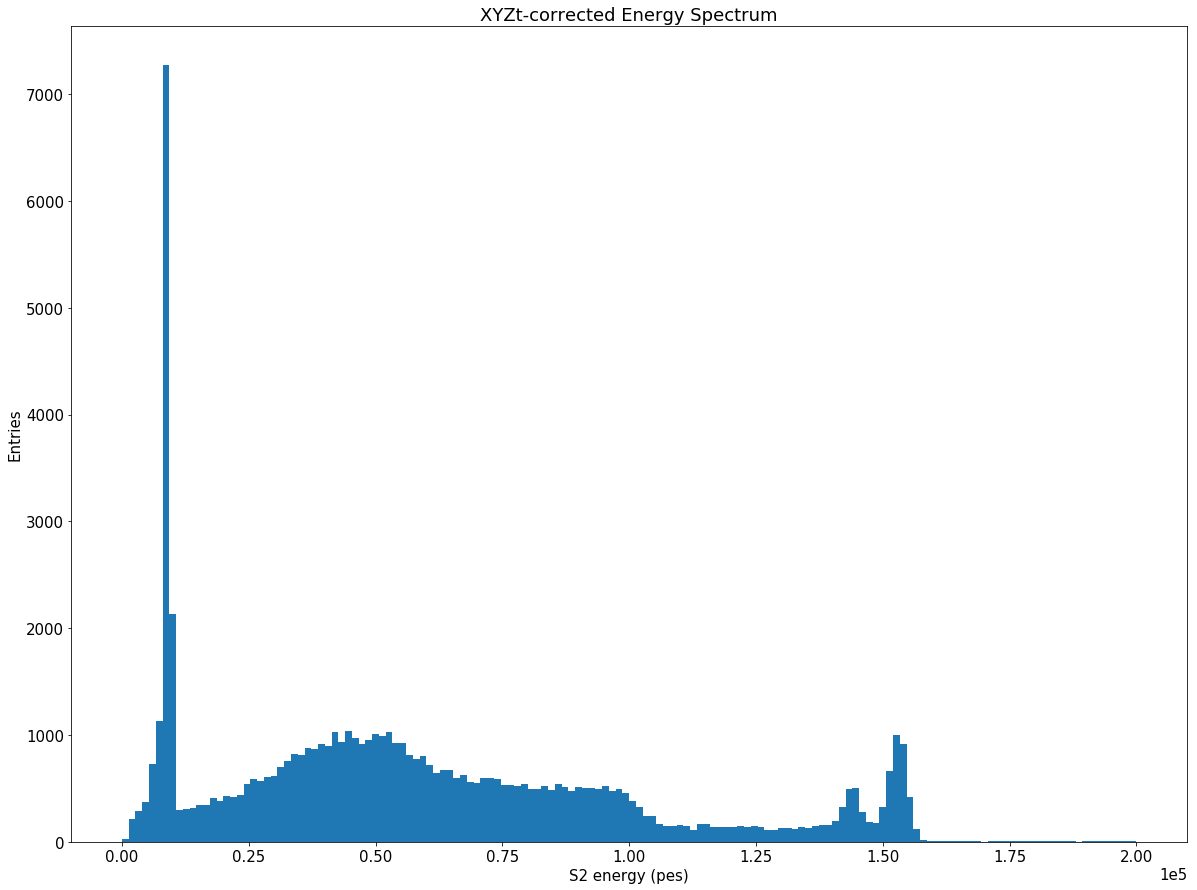

In [138]:
data = full
Efid_zcorr = data.S2e.values * Zcorr(data.Z.values).value *xy_map(data.X.values,data.Y.values).value
plt.figure(figsize=(20,15))
plt.hist(Efid_zcorr, 150, range=[0,2e5])
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.savefig("Corrected_spectrum.pdf")
labels("S2 energy (pes)", "Entries", "XYZt-corrected Energy Spectrum")
save("S2energyCorr")

In [39]:
f.values[1]

148628.14819533992

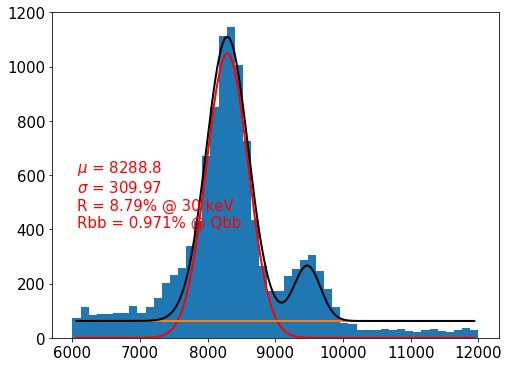

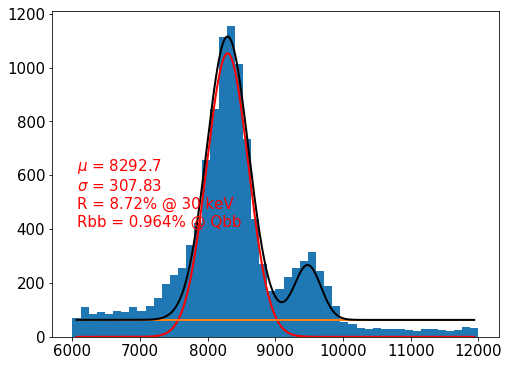

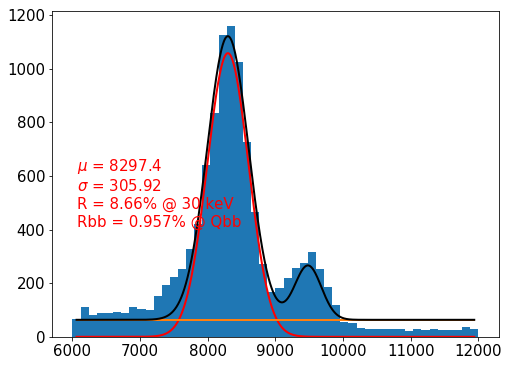

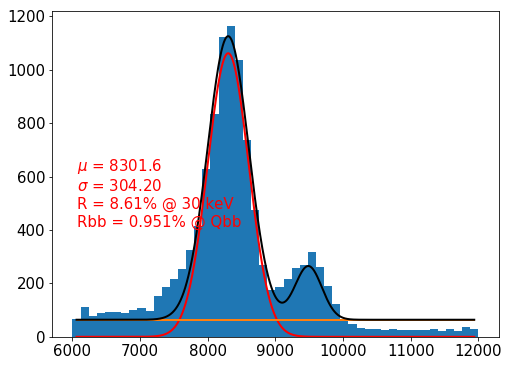

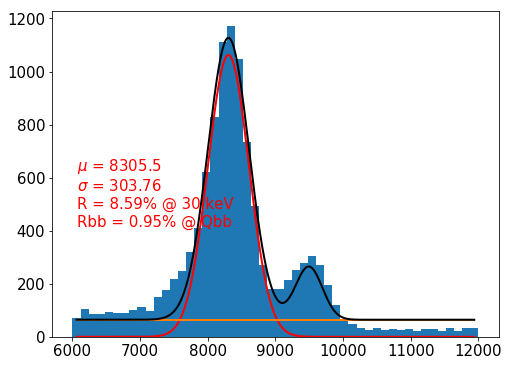

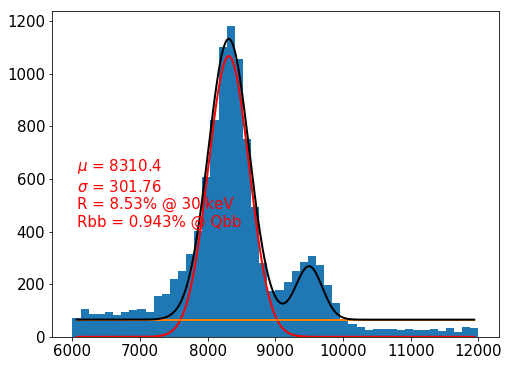

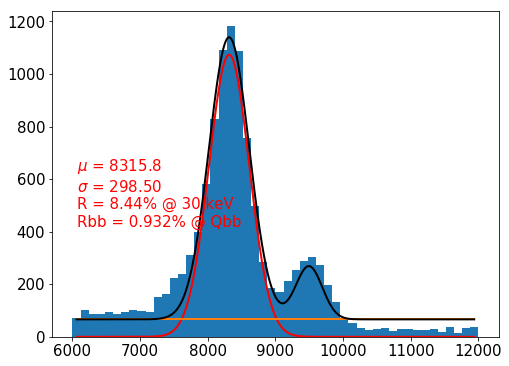

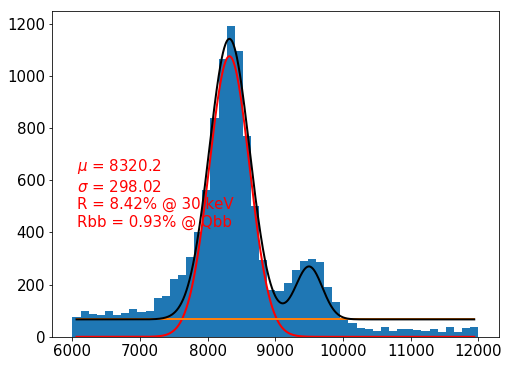

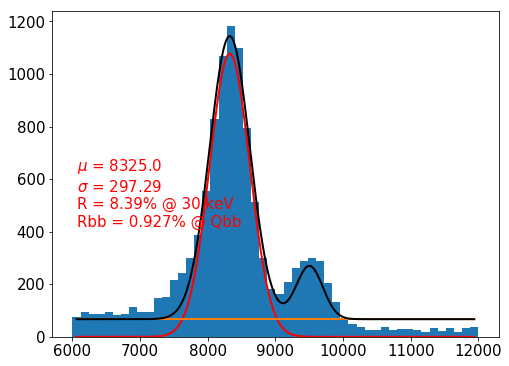

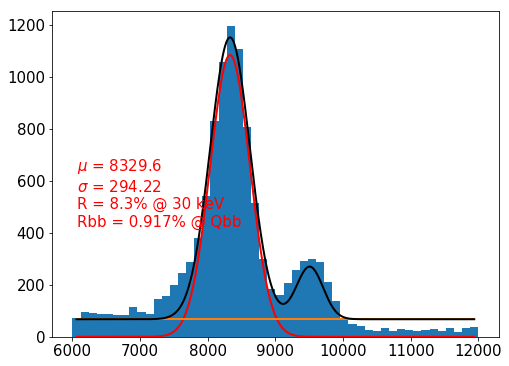

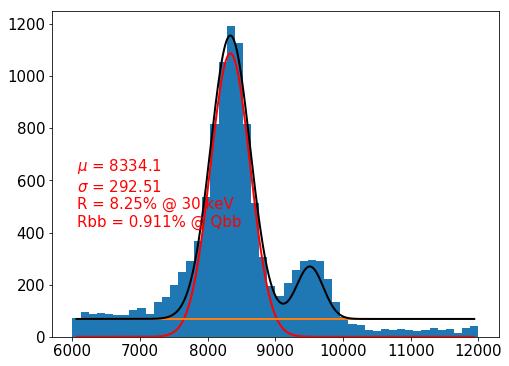

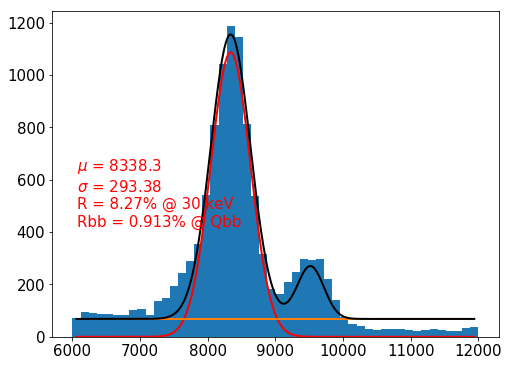

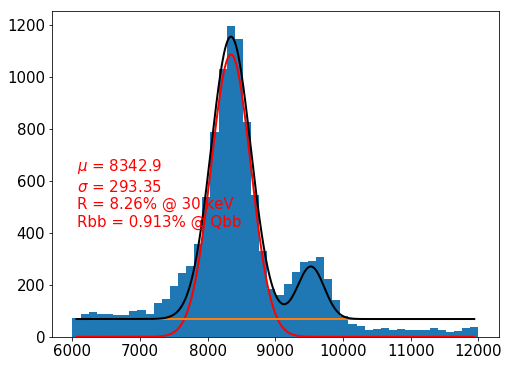

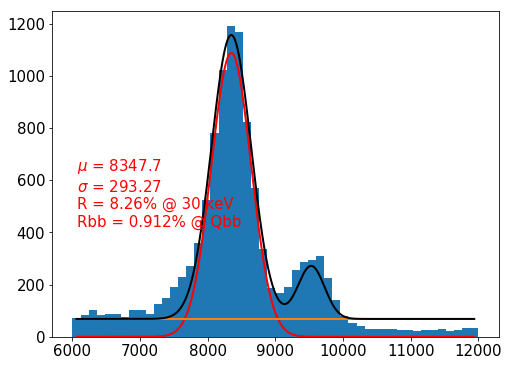

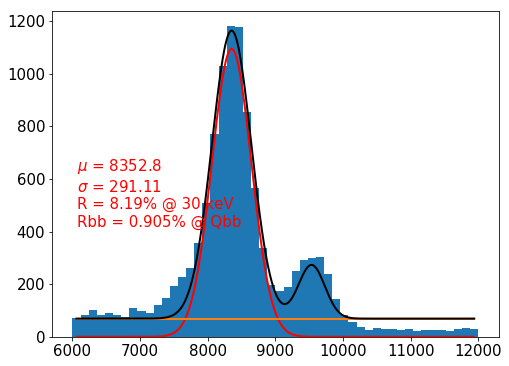

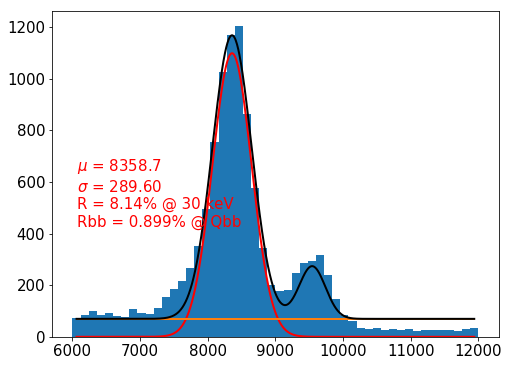

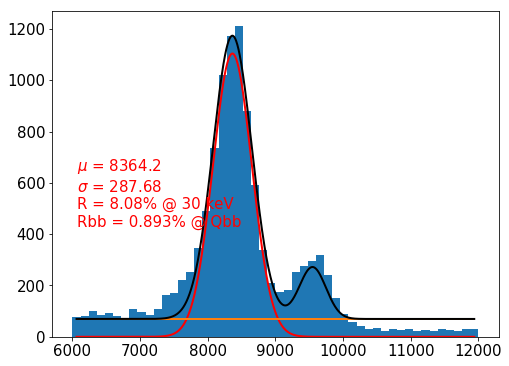

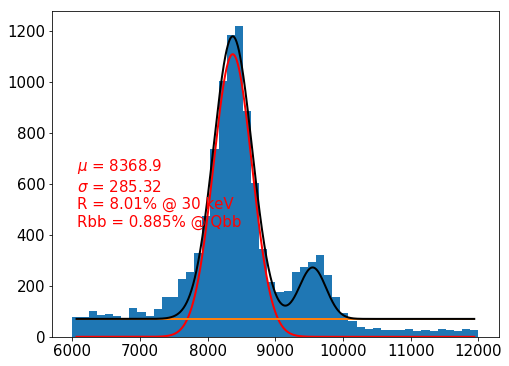

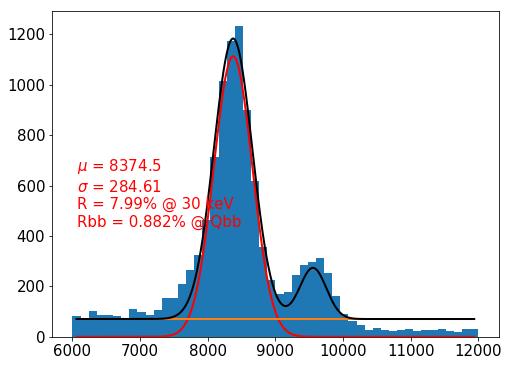

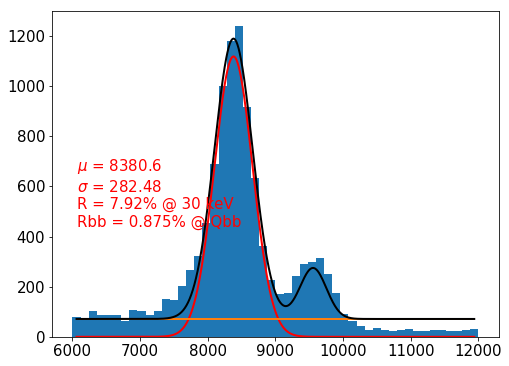

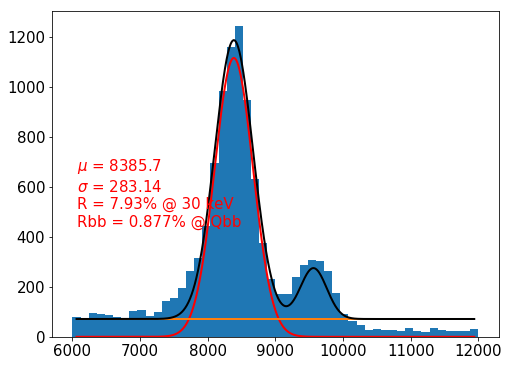

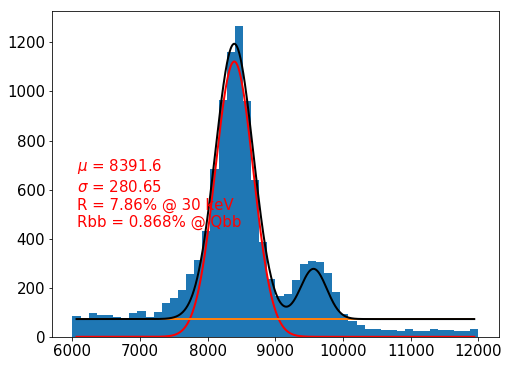

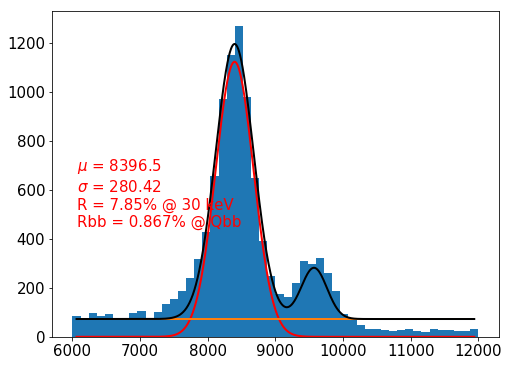

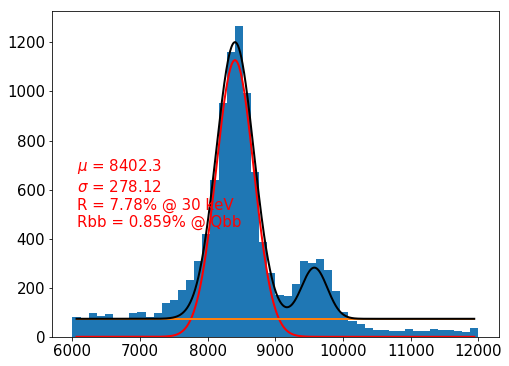

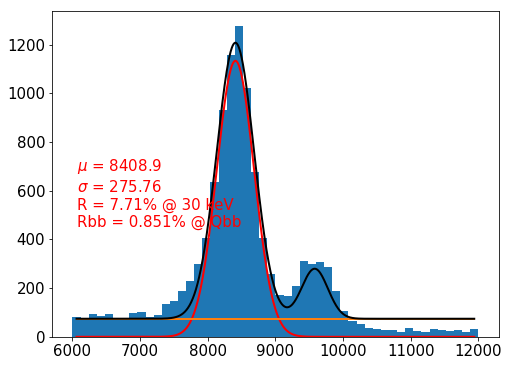

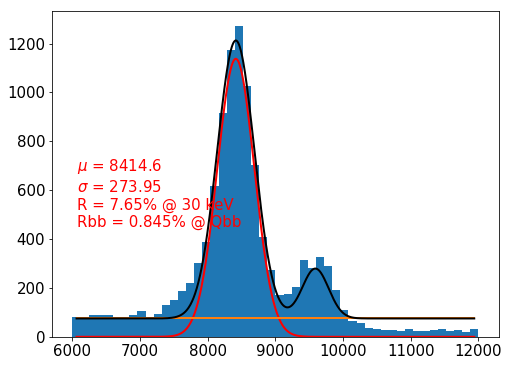

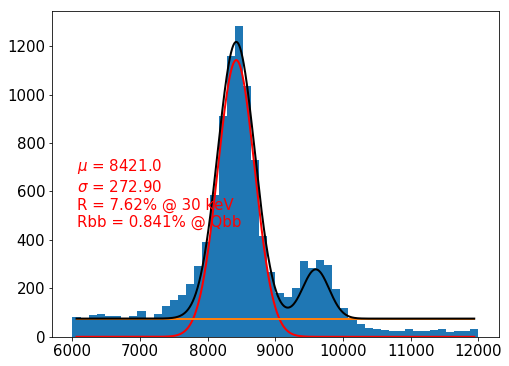

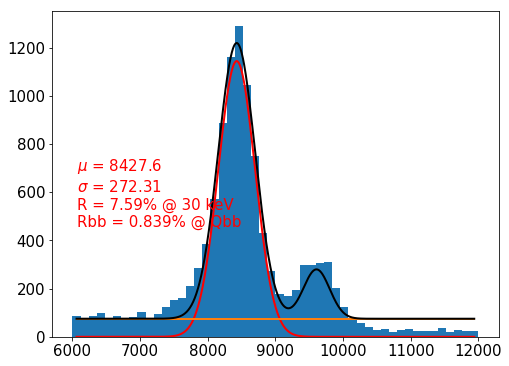

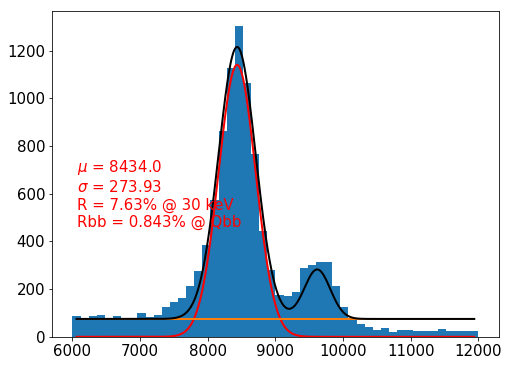

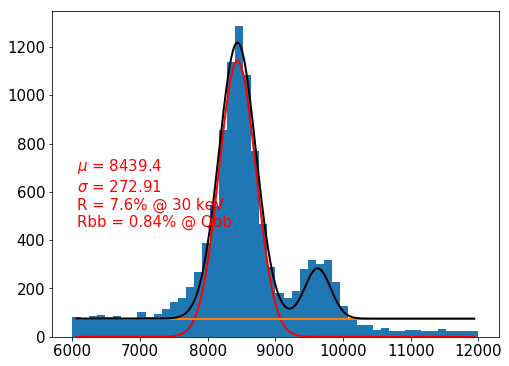

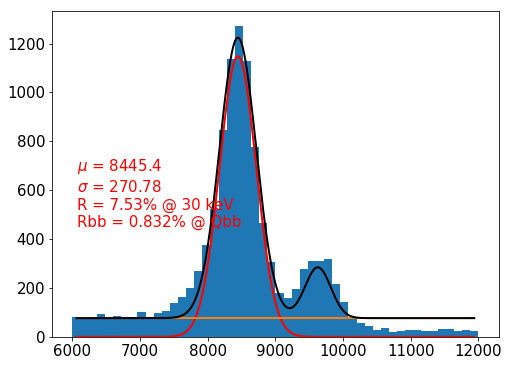

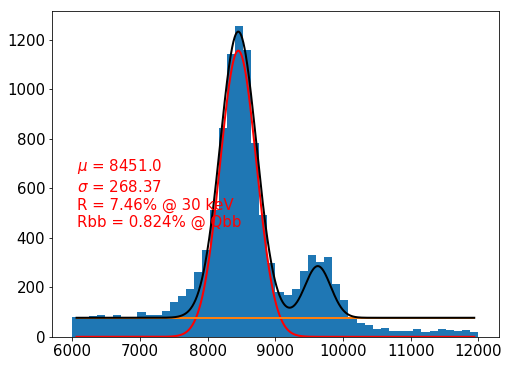

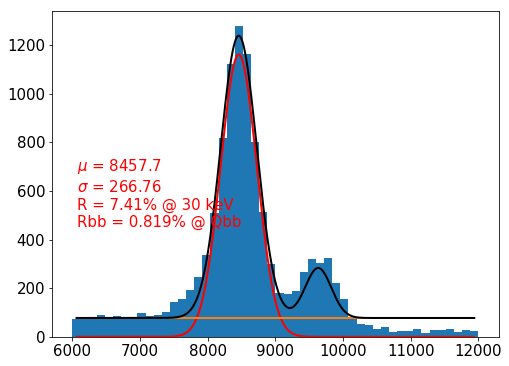

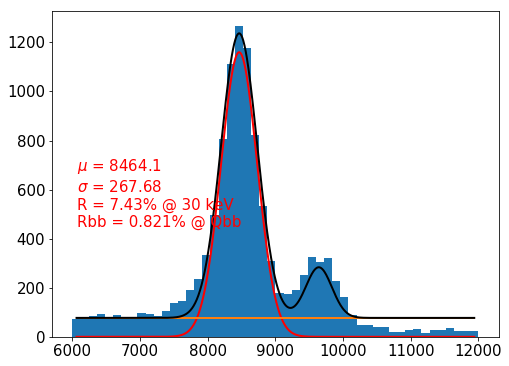

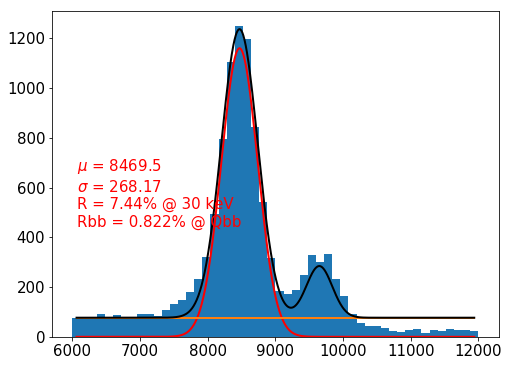

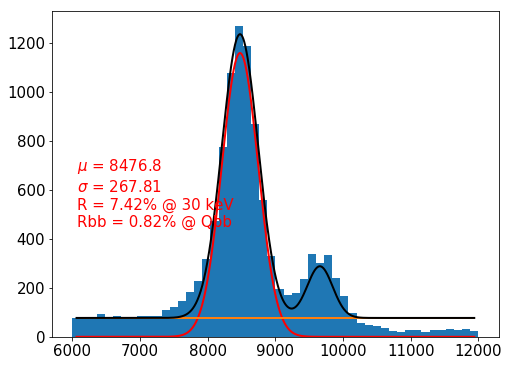

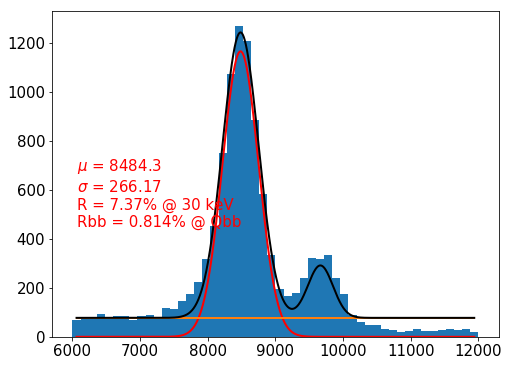

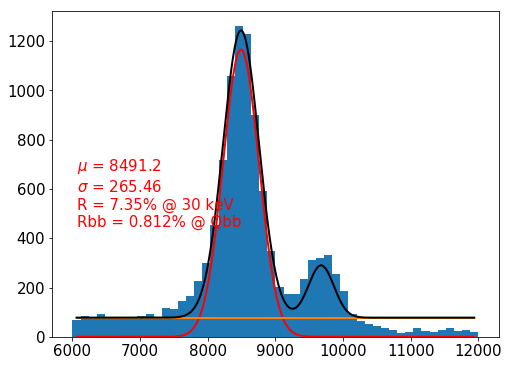

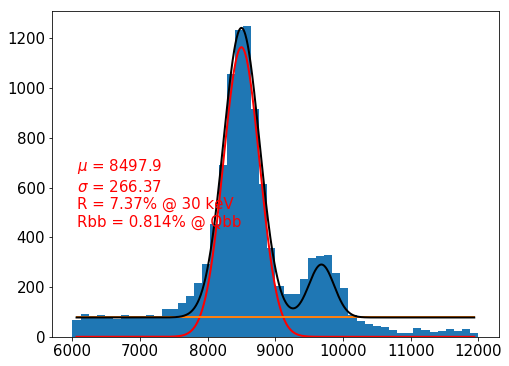

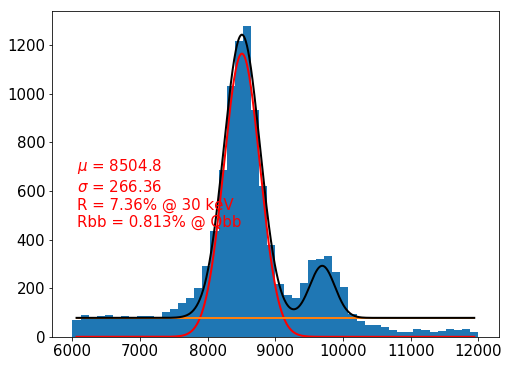

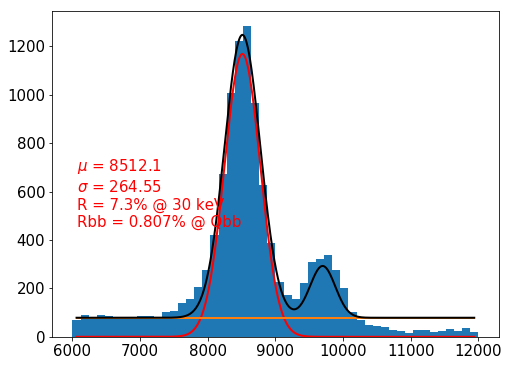

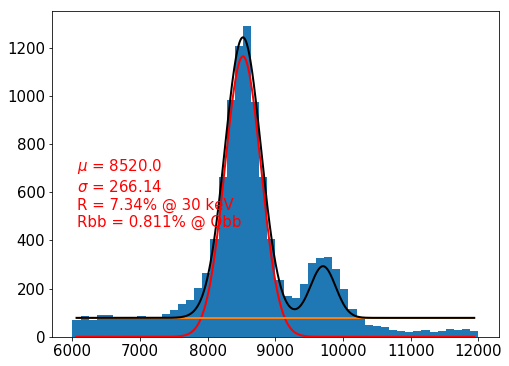

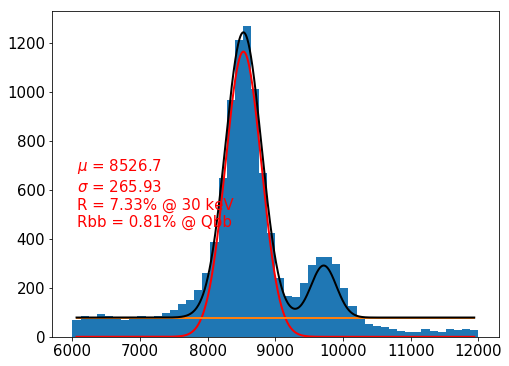

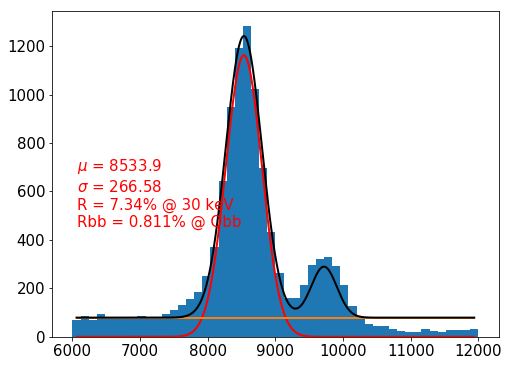

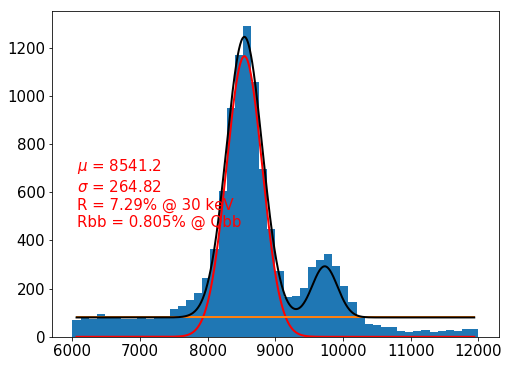

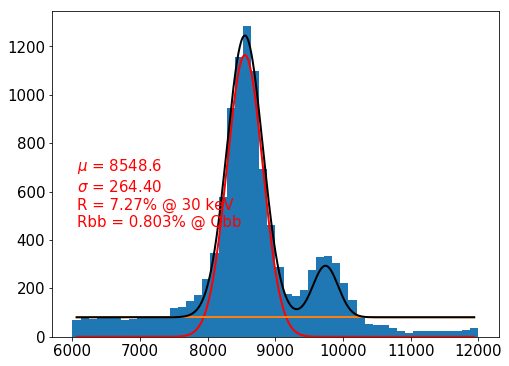

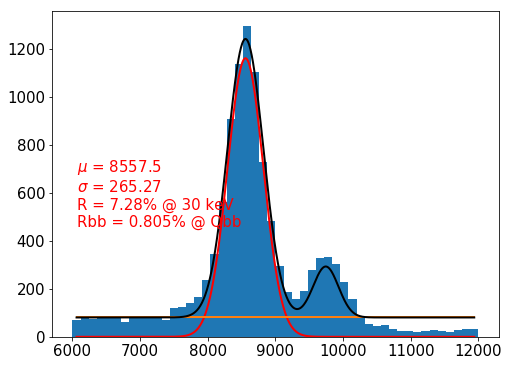

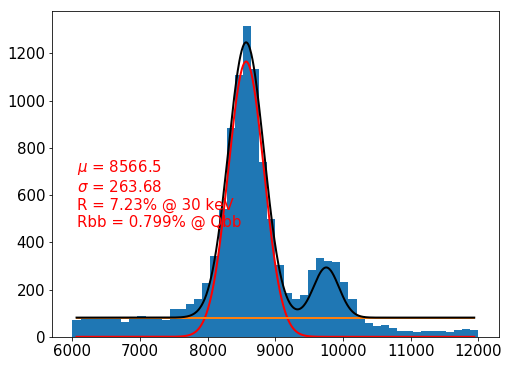

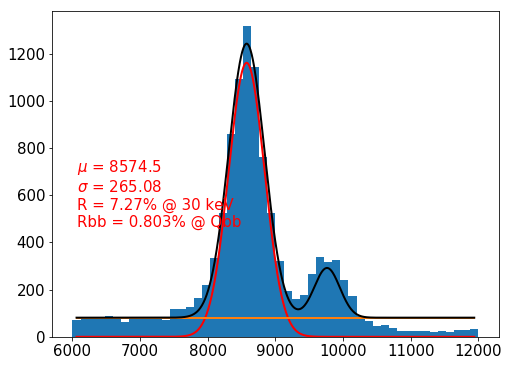

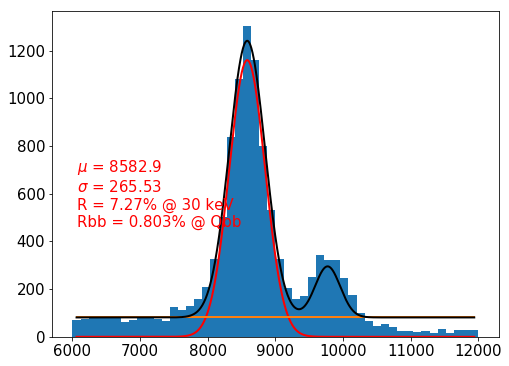

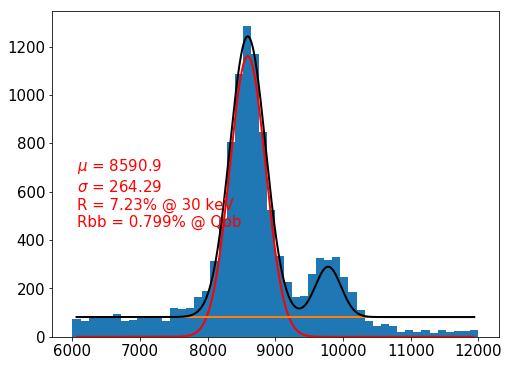

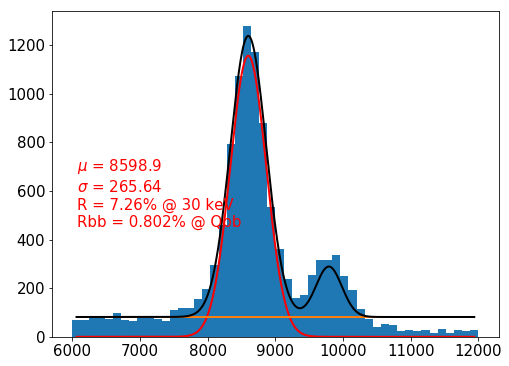

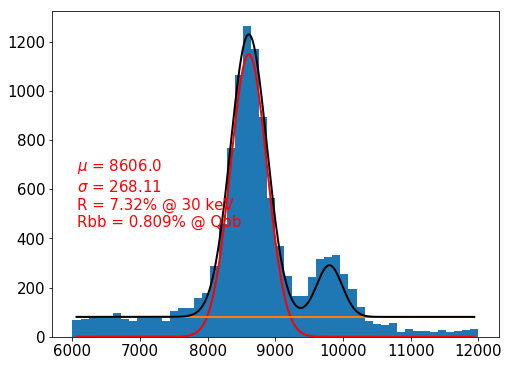

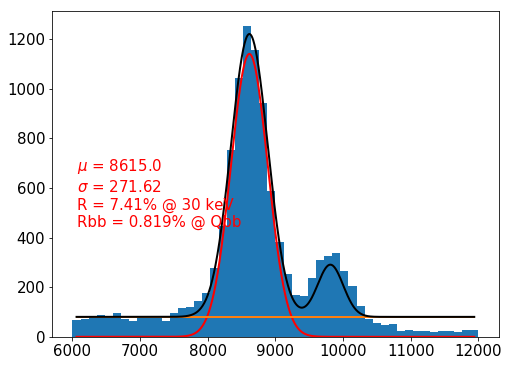

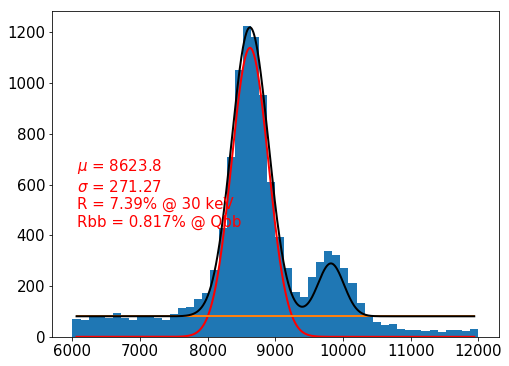

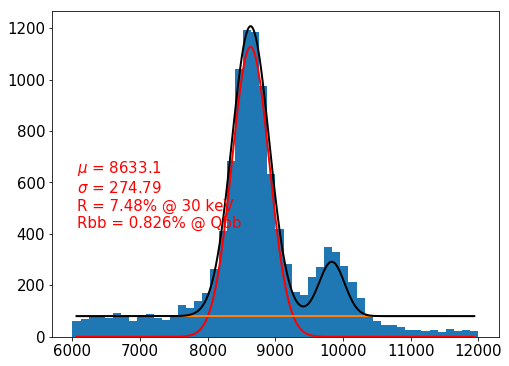

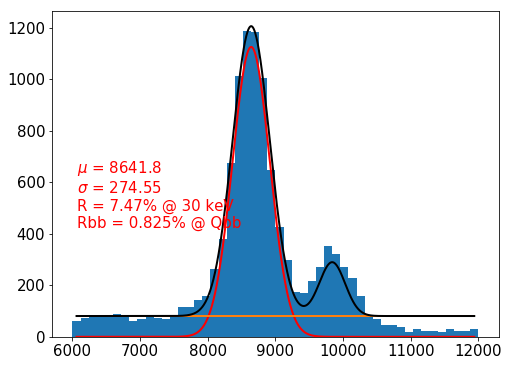

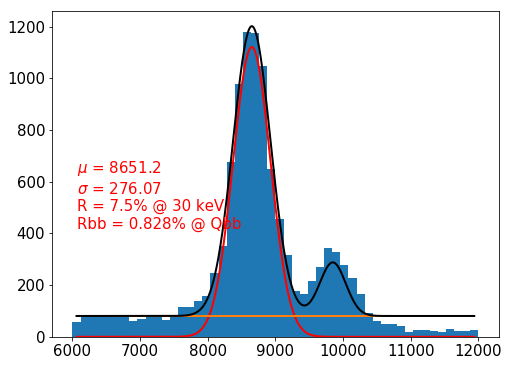

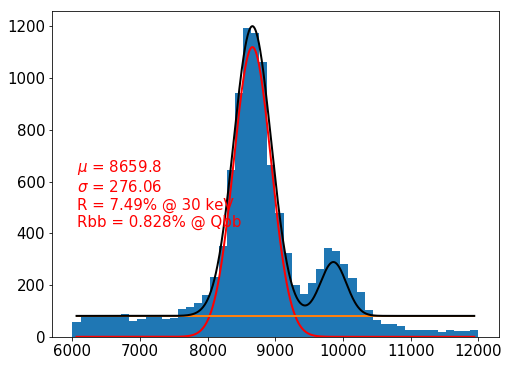

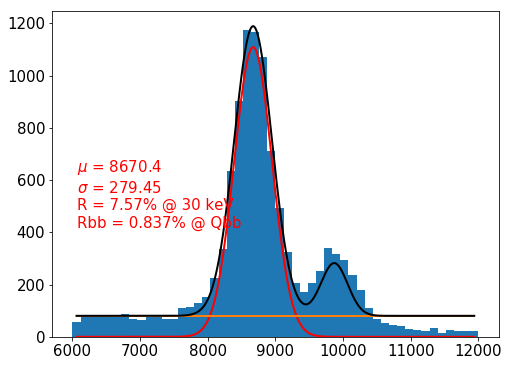

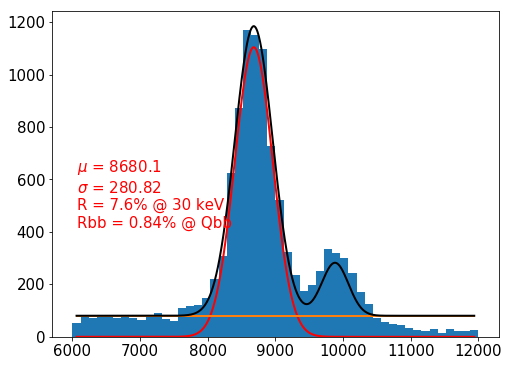

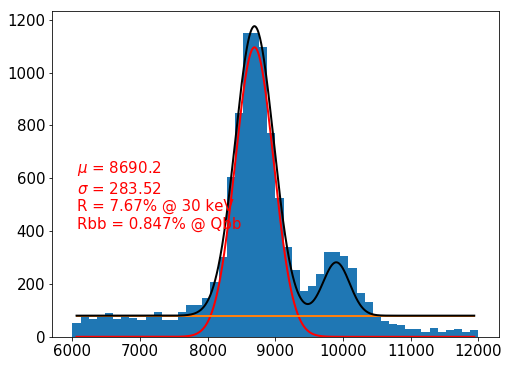

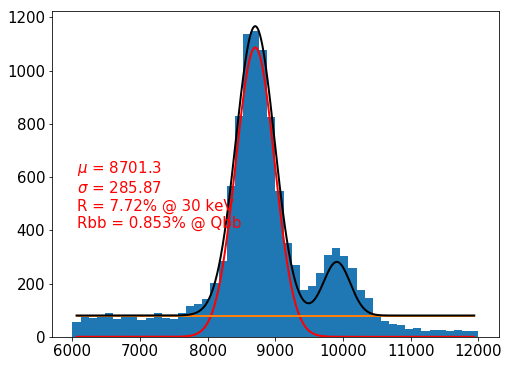

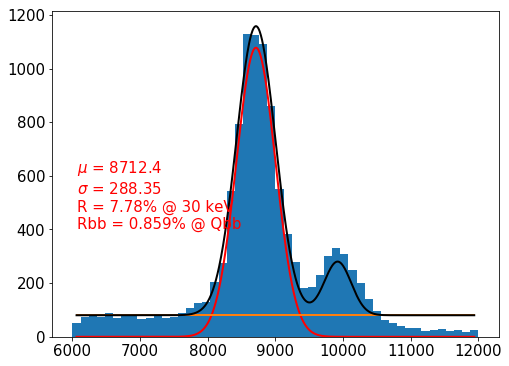

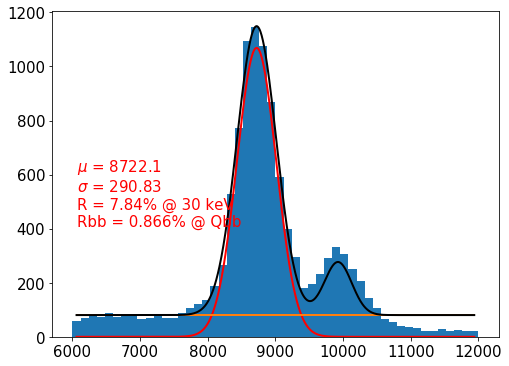

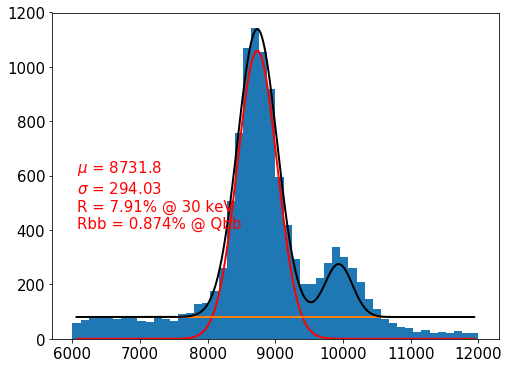

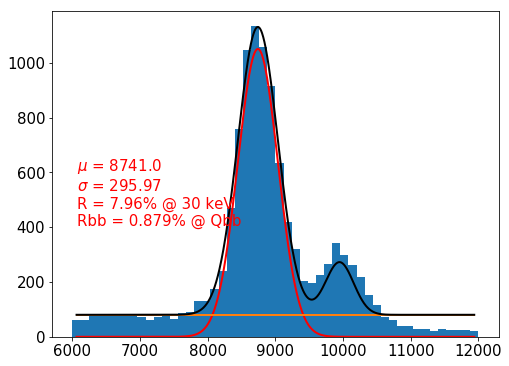

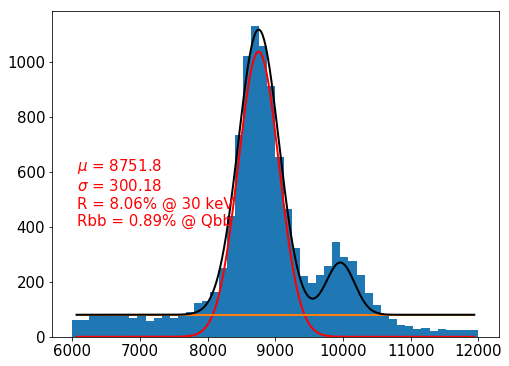

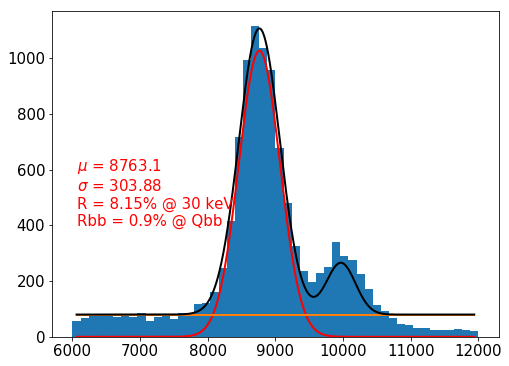

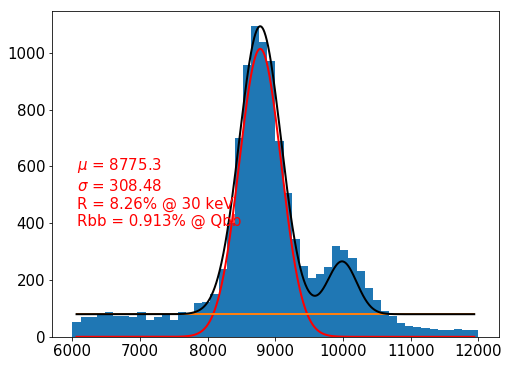

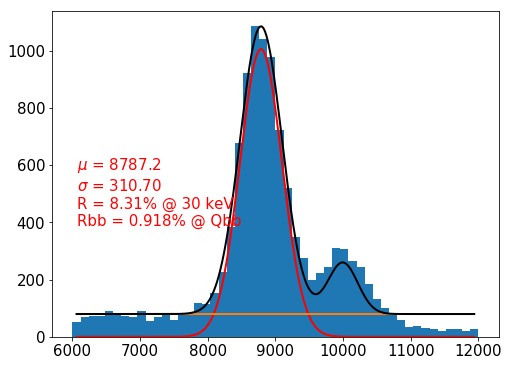

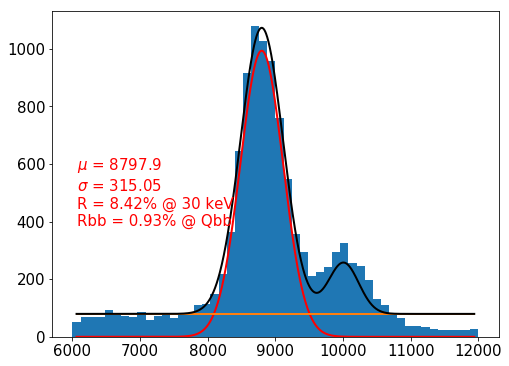

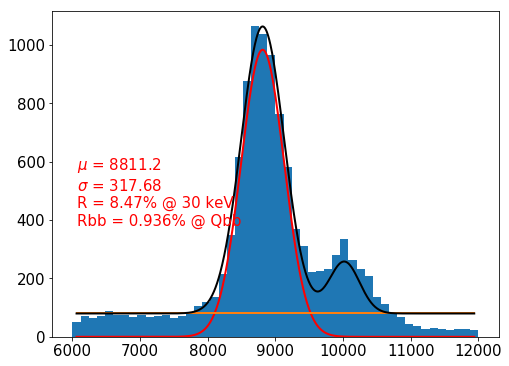

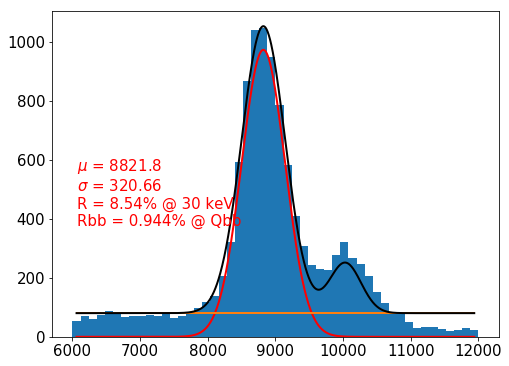

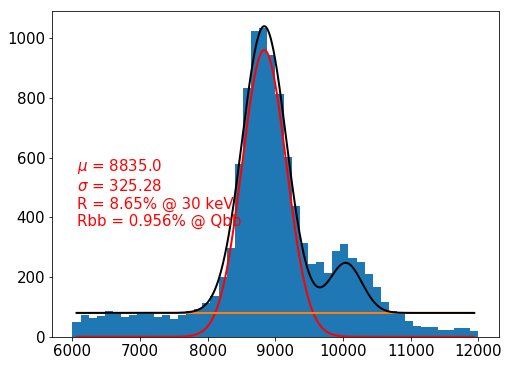

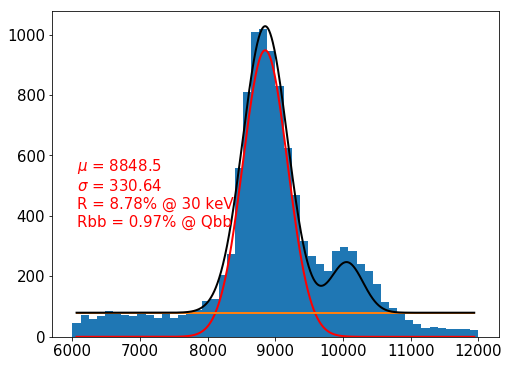

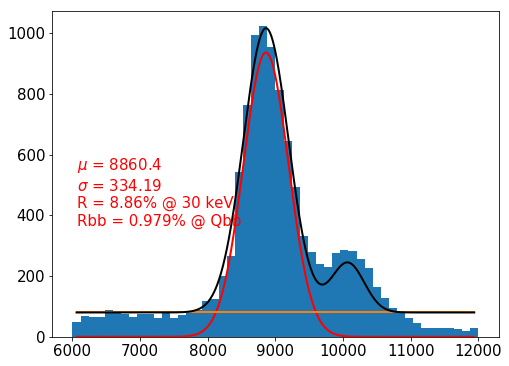

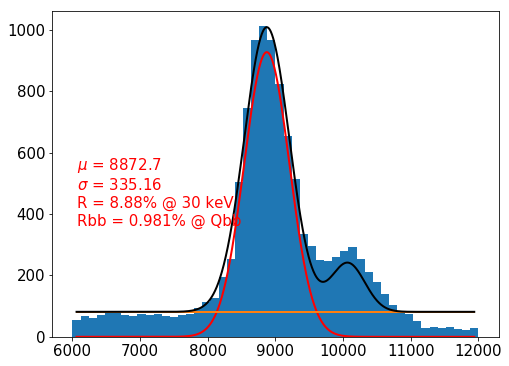

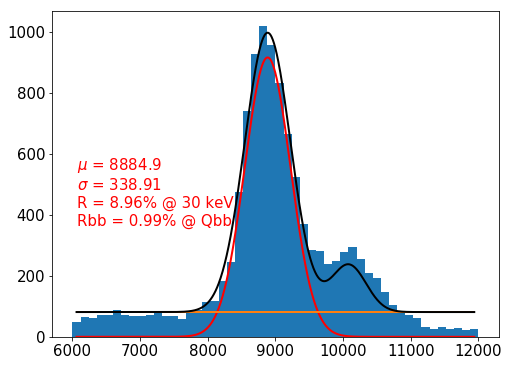

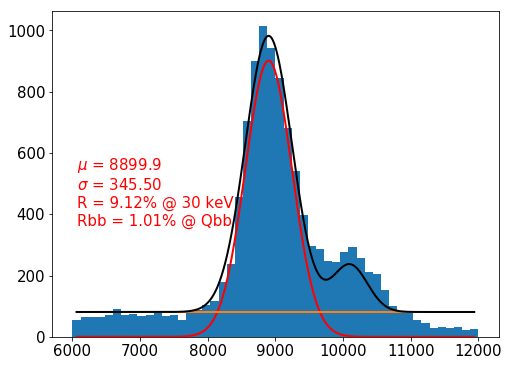

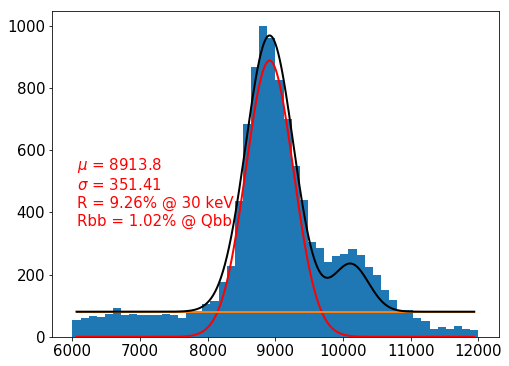

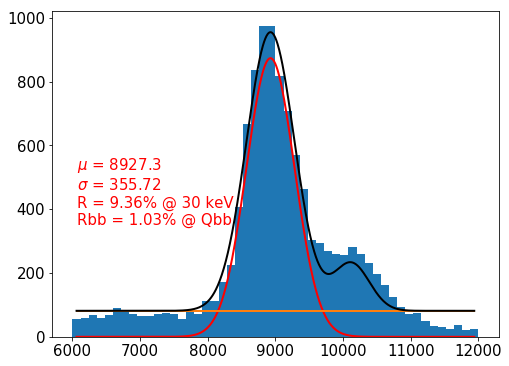

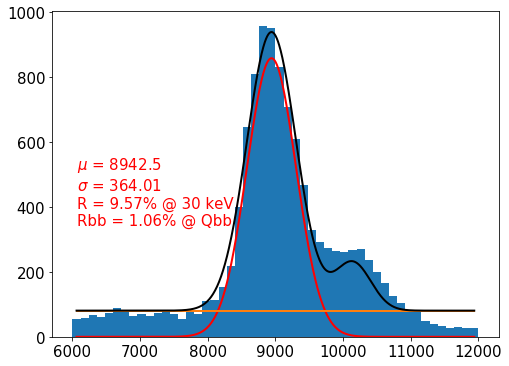

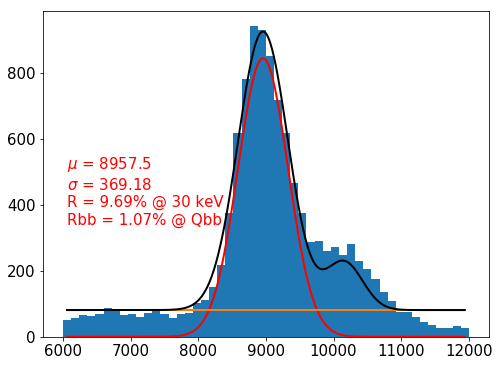

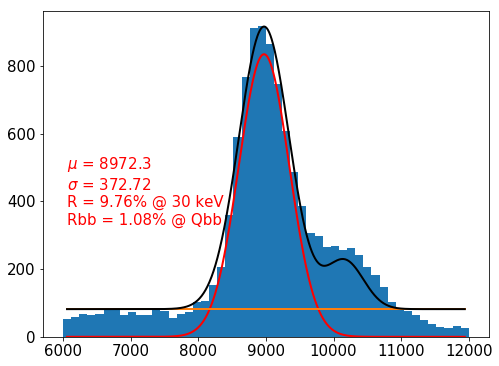

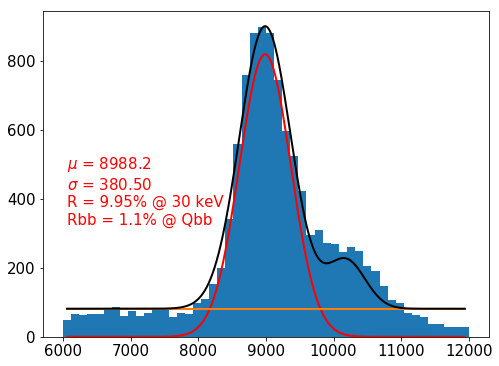

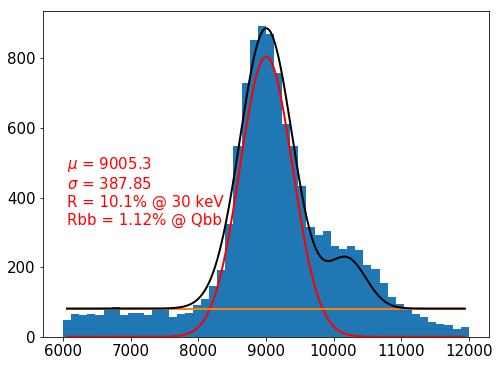

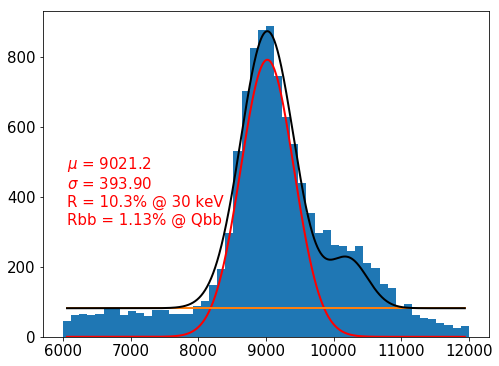

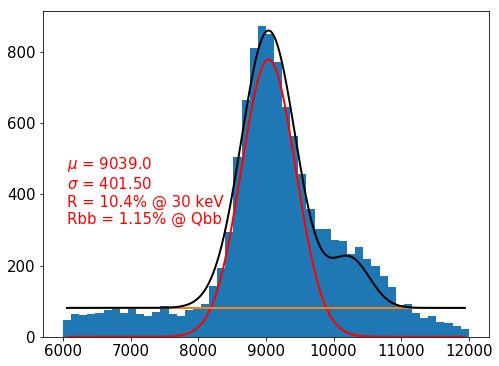

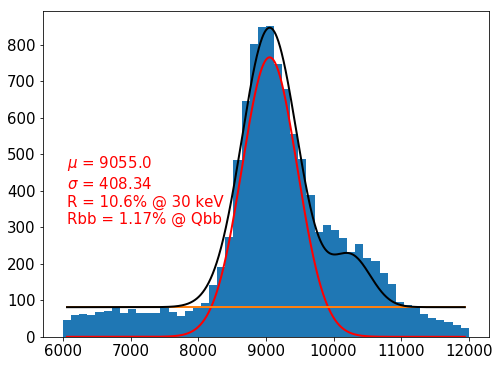

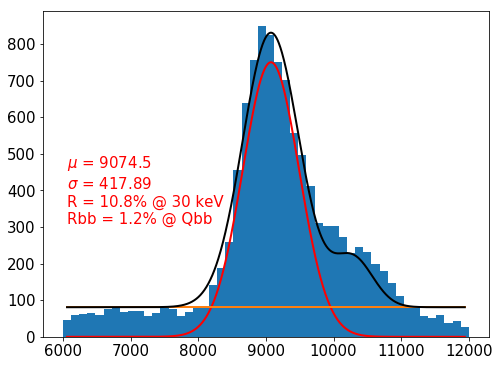

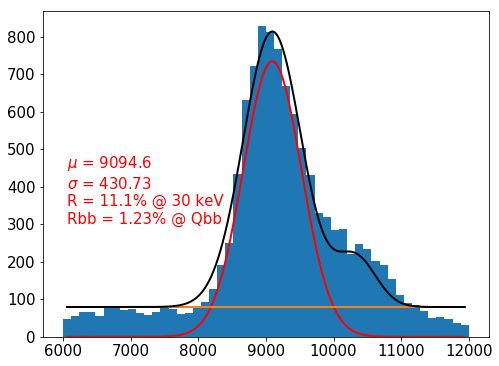

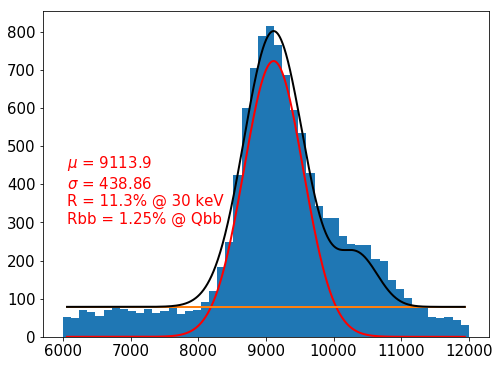

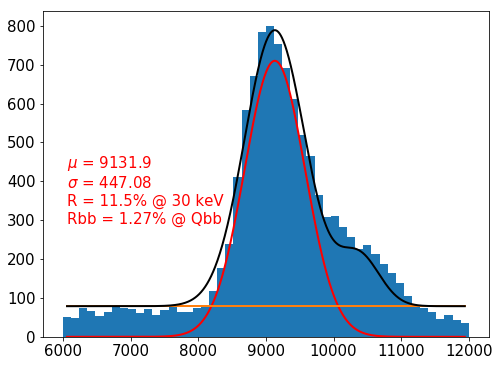

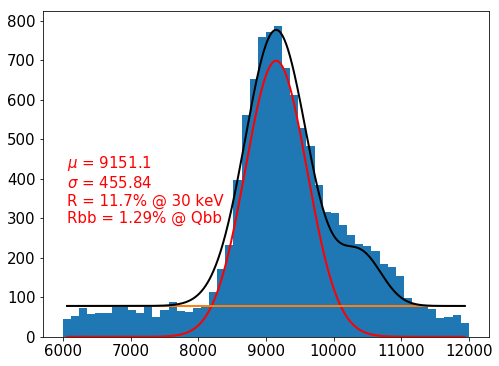

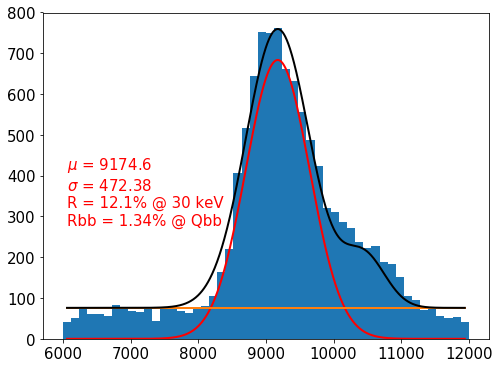

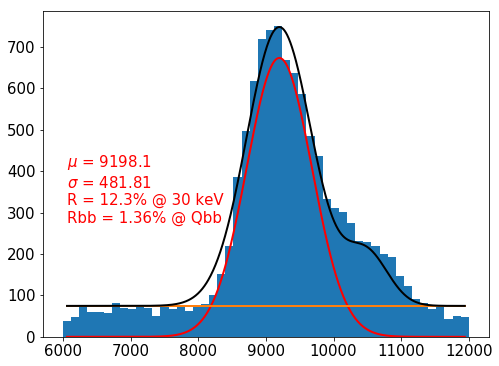

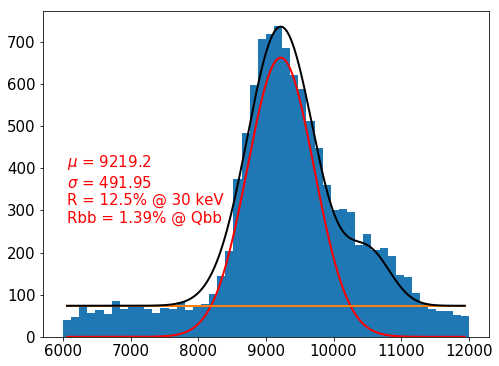

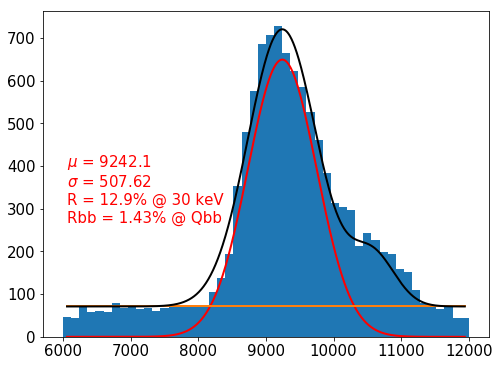

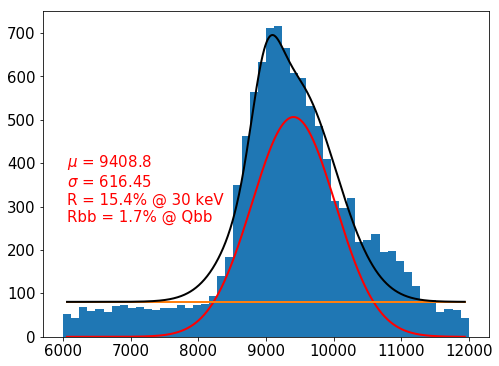

In [148]:
lf_base  = 1039.2
lf_err   = 31.5
nsigmas  = 10
npoints  = 100

lf_list  = lf_base + nsigmas*lf_err - np.linspace(0, 2*nsigmas*lf_err,npoints)
res_list = []

for lfi in lf_list:
    Zcorr_aux = corrf.LifetimeCorrection(lfi, lf_err)
    
    data = full
    Efull_zcorr = data.S2e.values * Zcorr_aux(data.Z.values).value * xy_map(data.X.values,data.Y.values).value
    y, x, _ = hist(Efull_zcorr, 50, range=[6e3, 12e3])

    seed = 1e4,  9000, 300, 1e3, 10000, 500, 10
    low  =  10,  8000,  50, 1e2,  9000,  50, 0 
    upp  = 1e8, 10000, 900, 1e5, 11000, 500, 100
    f    = fitf.fit(two_gauss, x, y, seed, fit_range=(7.5e3,12e3), bounds=(low, upp))
    
    xrange = np.linspace(x[0], x[-1],1000)


    plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
    #plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=2)
    plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
    plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)
    plt.text(x[0], 1*max(y)/3+25, gausstext(f.values, 30), color=fitOpt)
    
    res_list.append(resolution(f.values,f.errors))
    

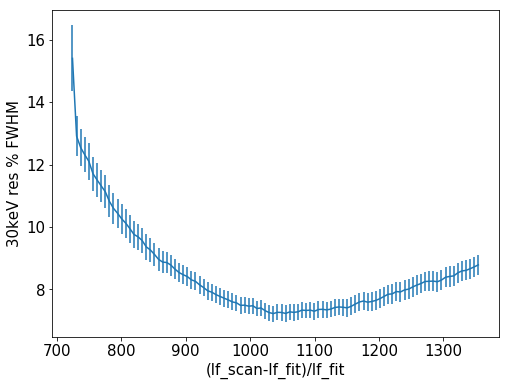

In [116]:
plt.errorbar(lf_list,[res_list[i][0][0] for i in range(npoints)],[res_list[i][0][1] for i in range(npoints)])
plt.xlabel('(lf_scan-lf_fit)/lf_fit')
plt.ylabel('30keV res % FWHM')

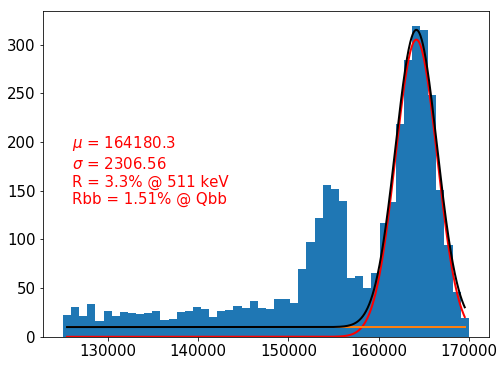

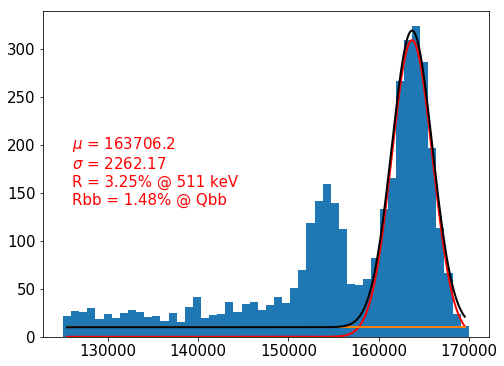

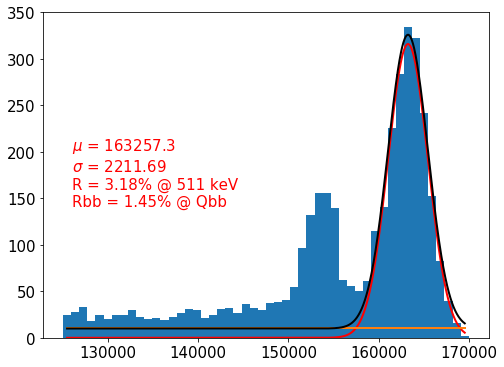

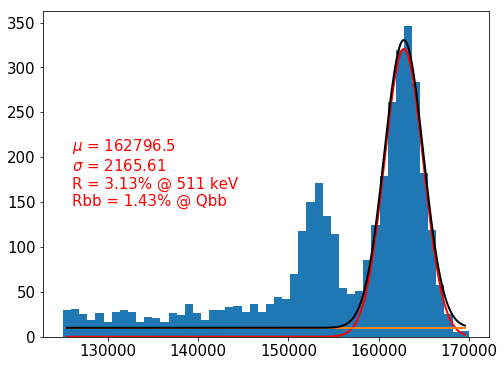

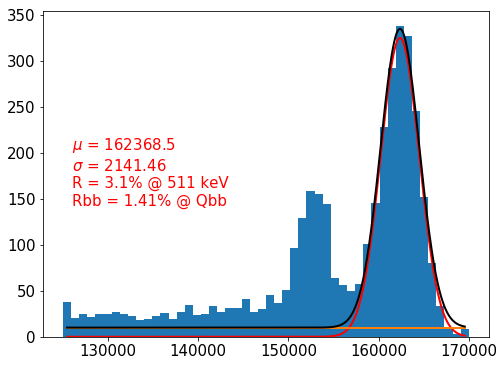

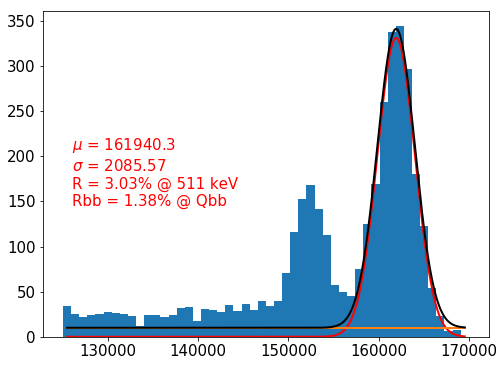

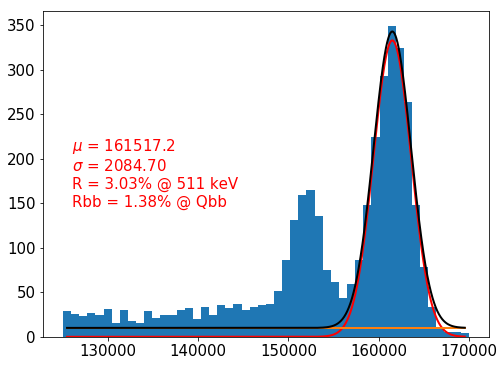

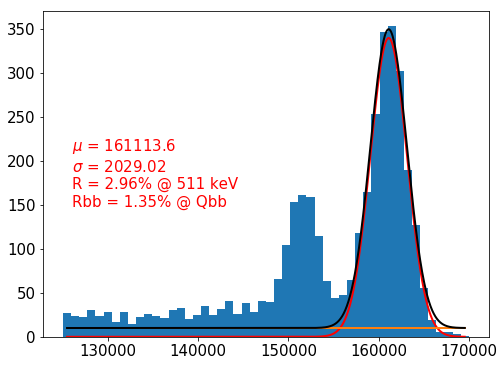

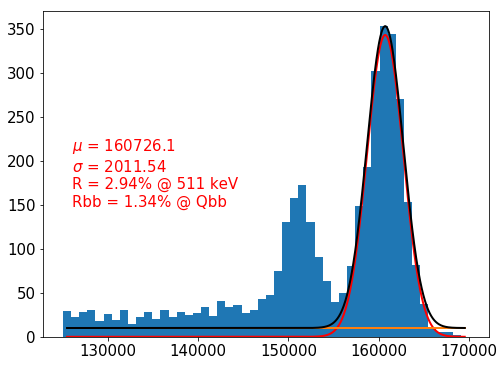

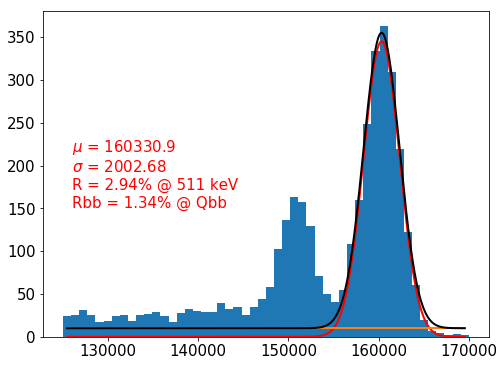

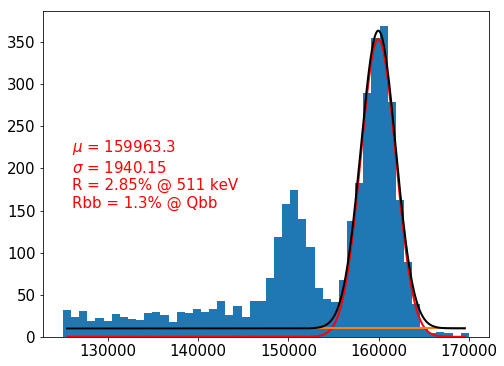

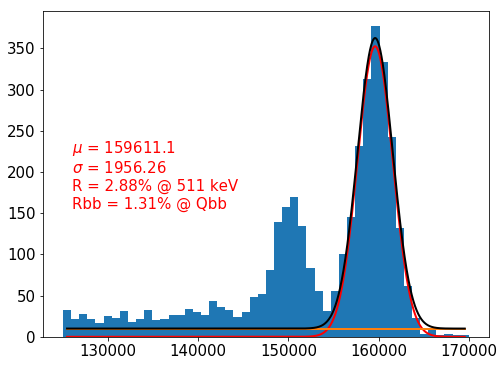

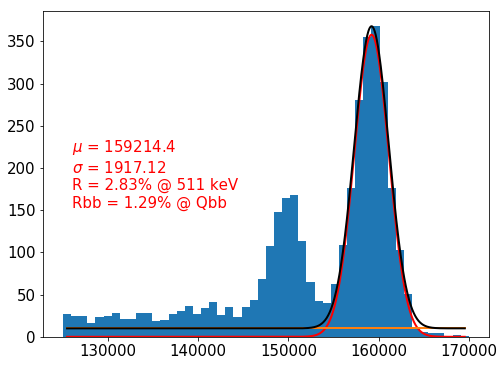

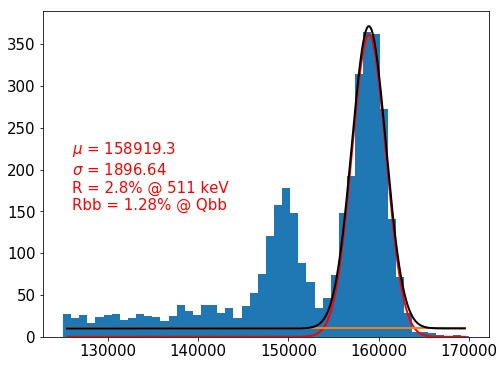

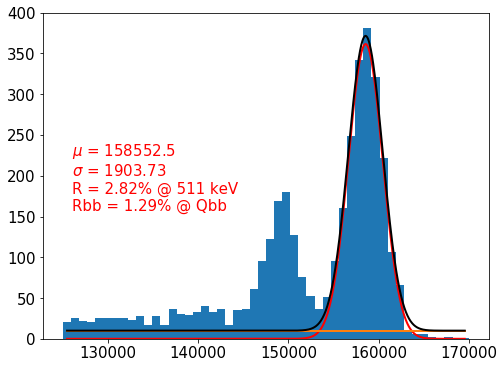

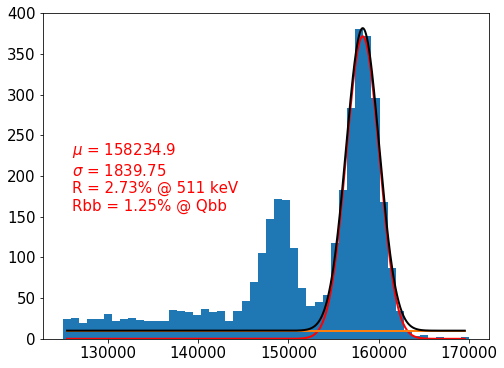

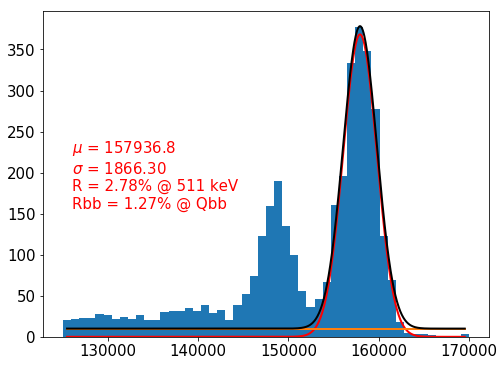

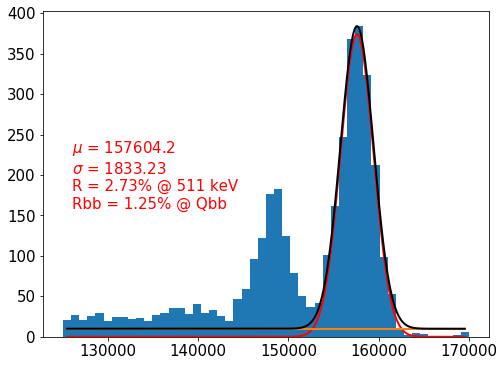

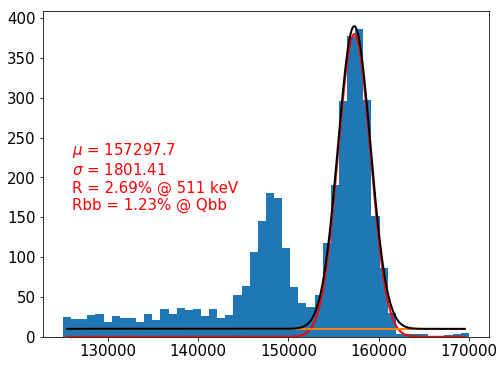

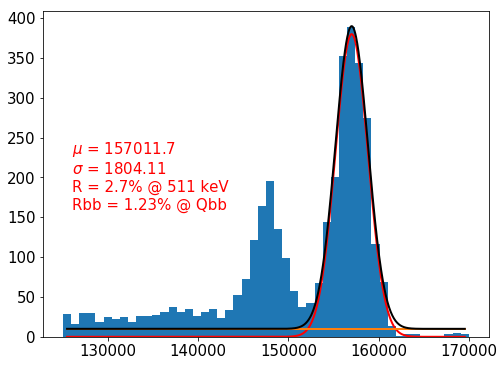

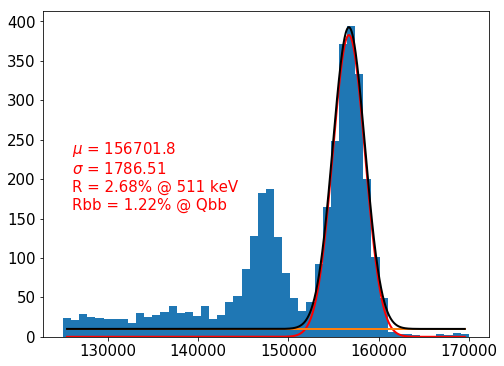

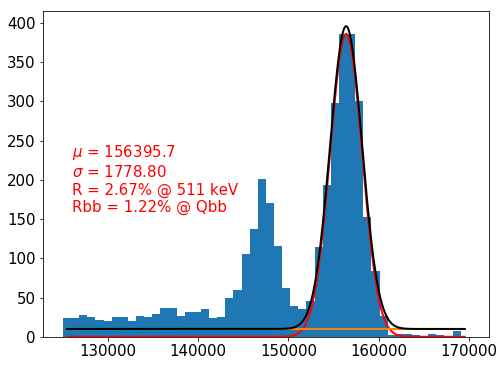

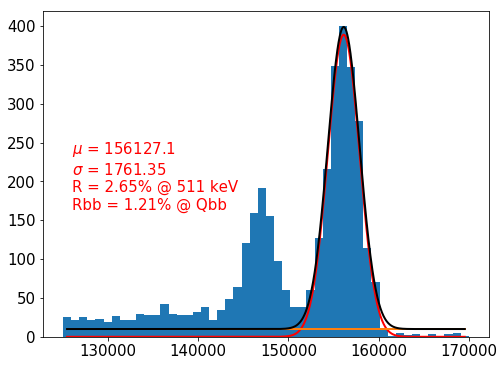

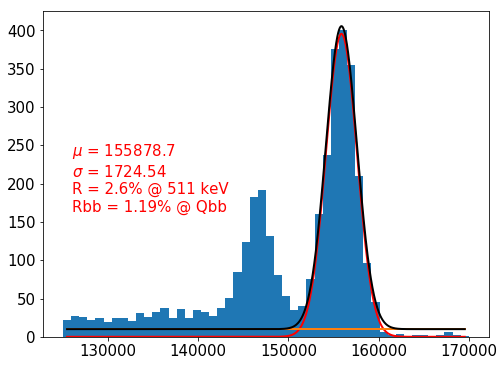

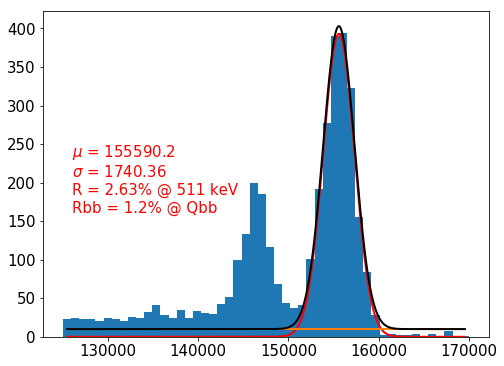

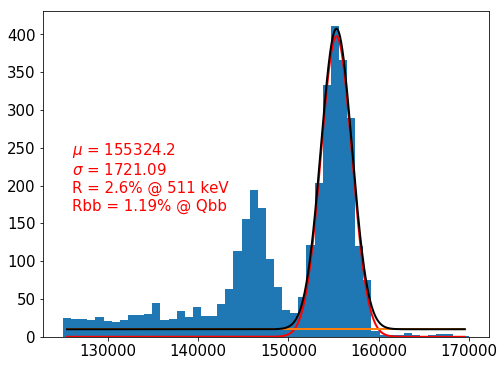

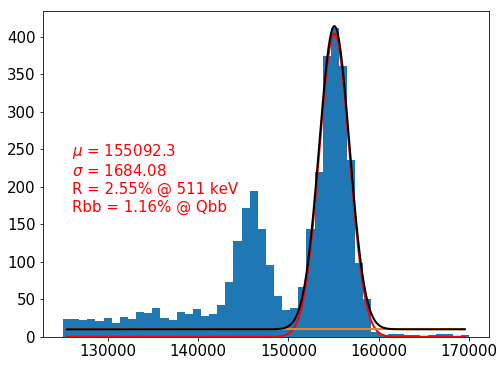

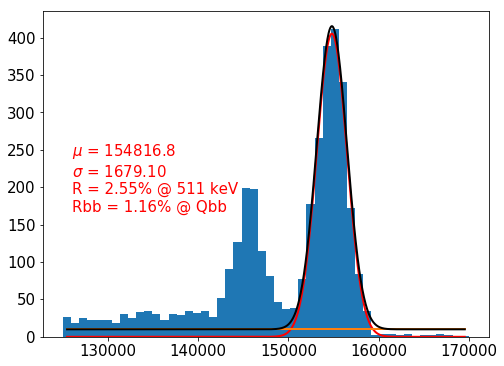

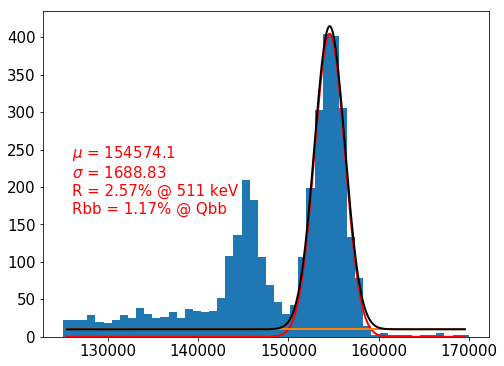

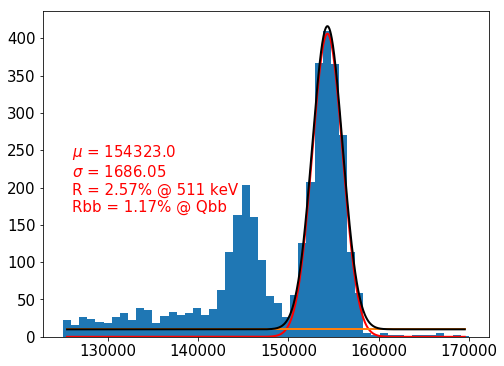

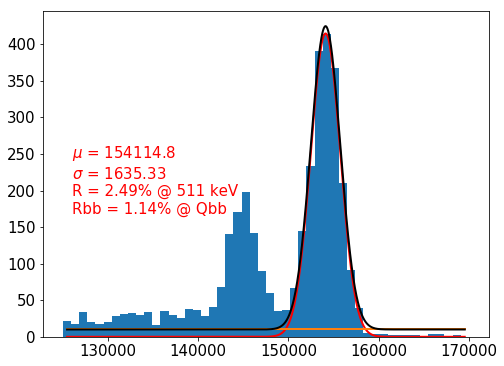

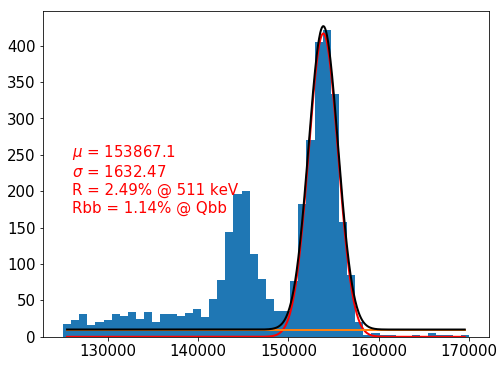

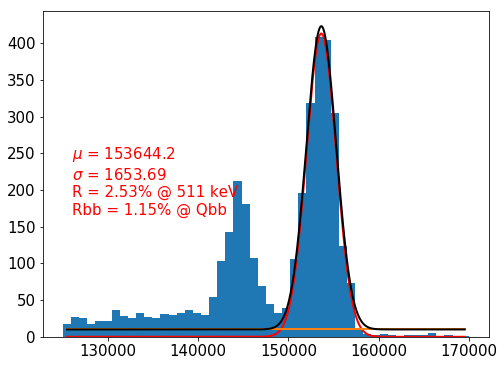

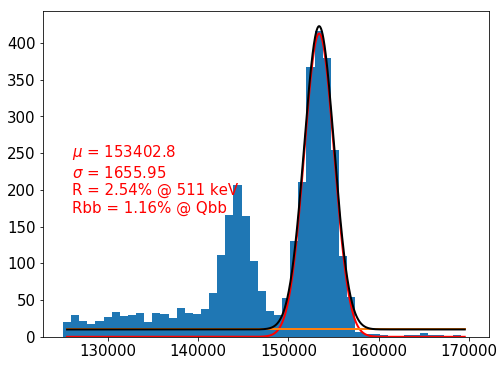

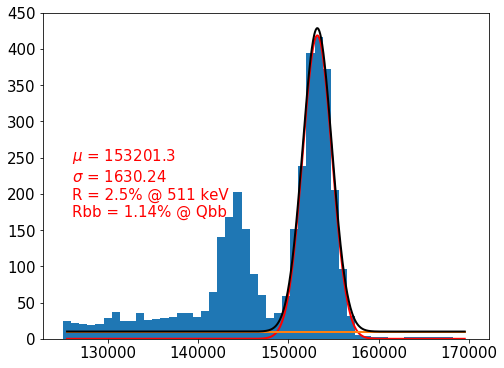

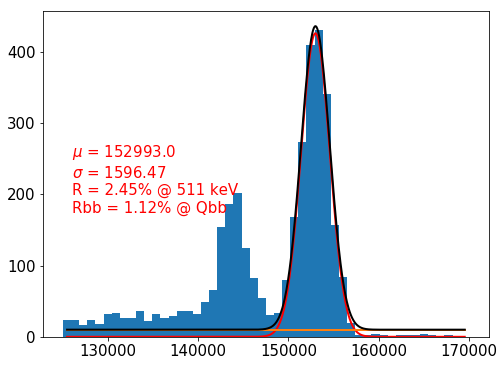

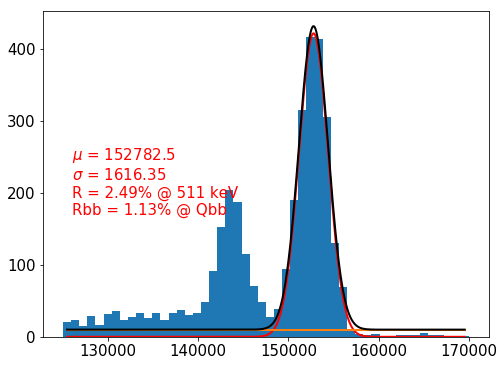

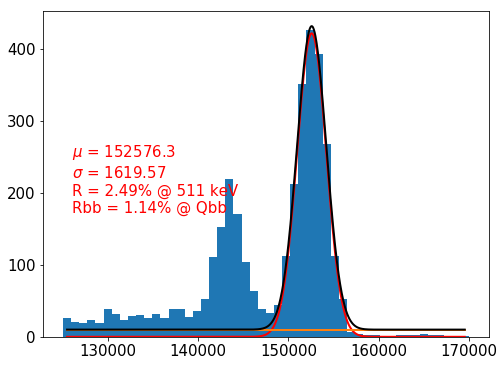

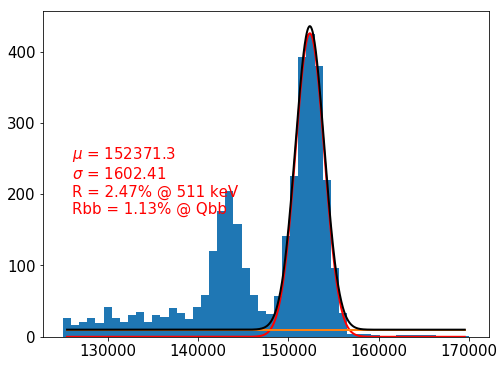

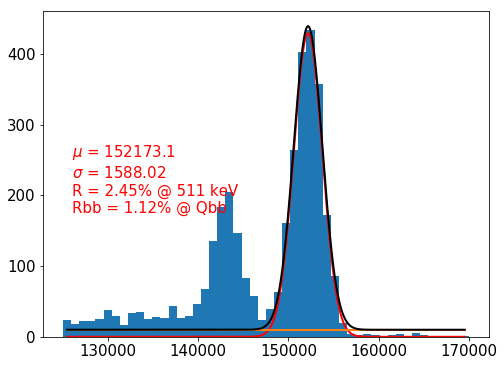

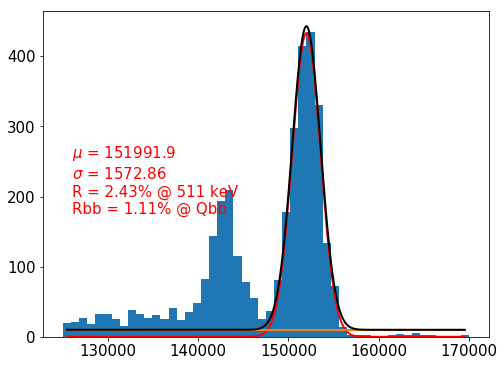

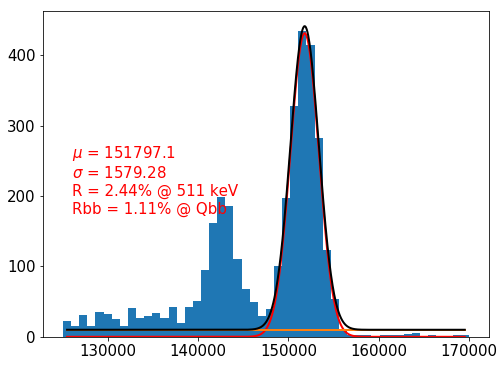

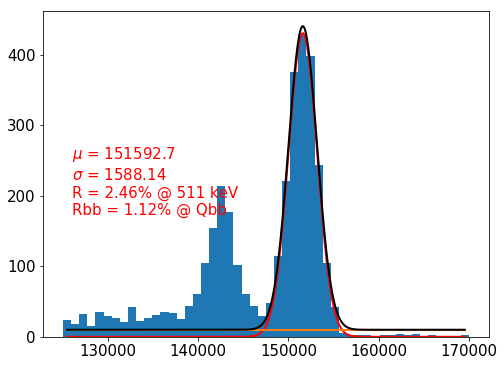

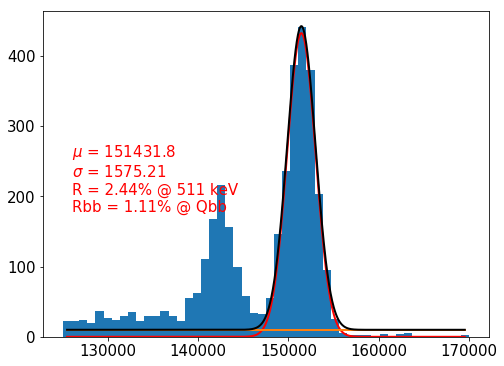

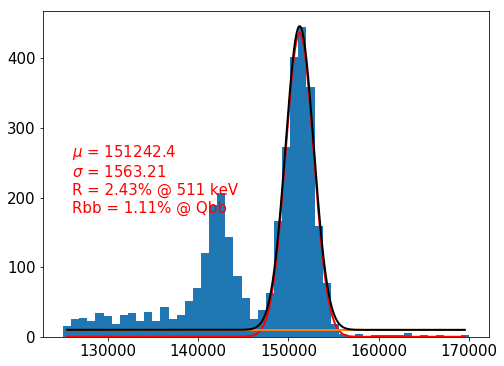

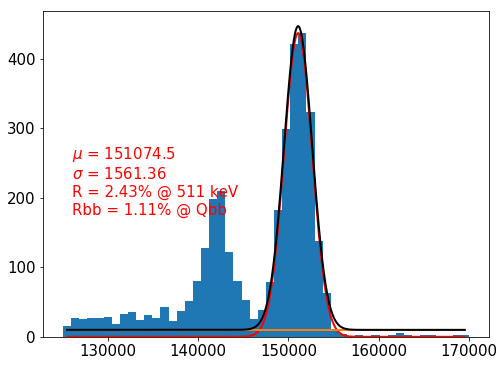

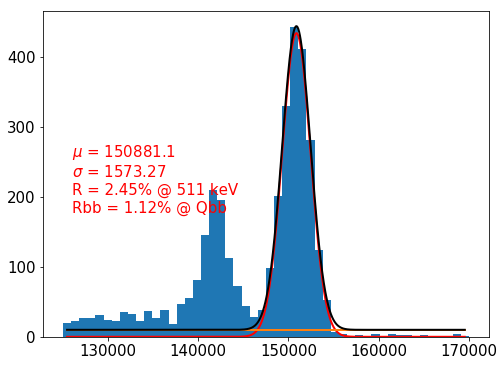

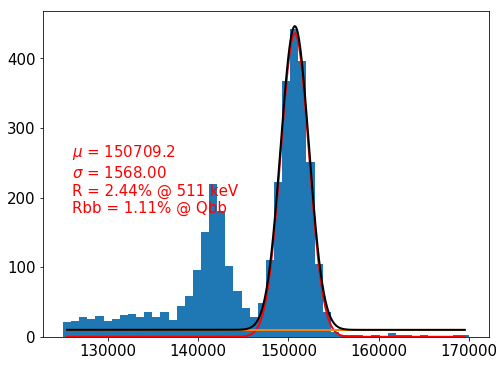

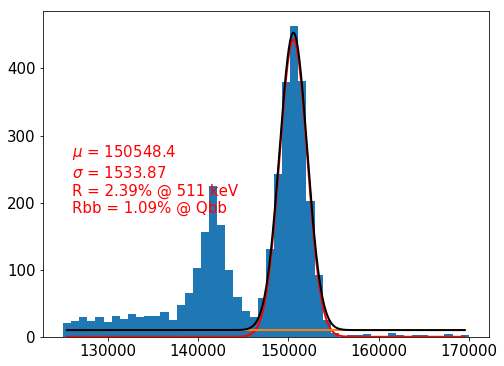

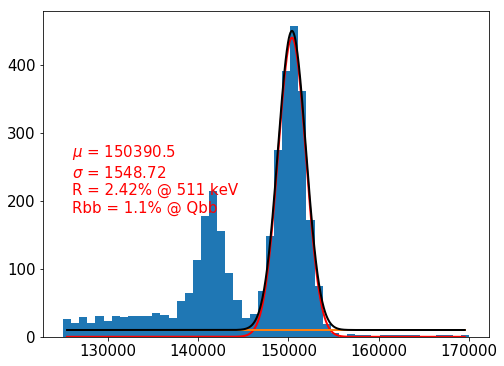

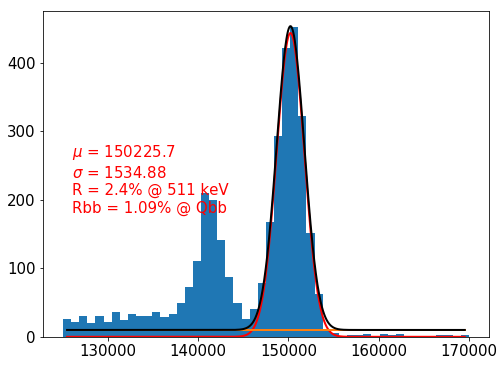

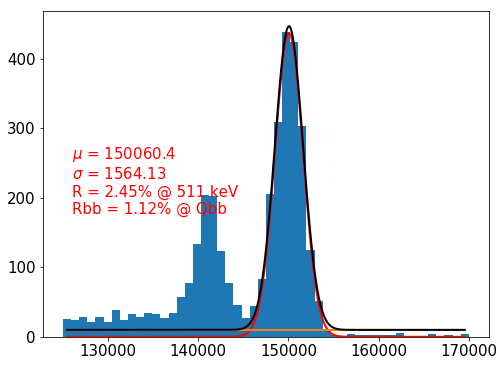

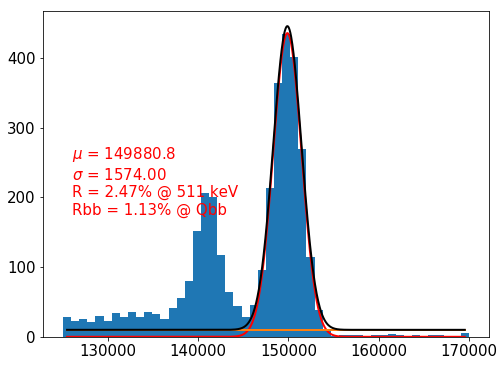

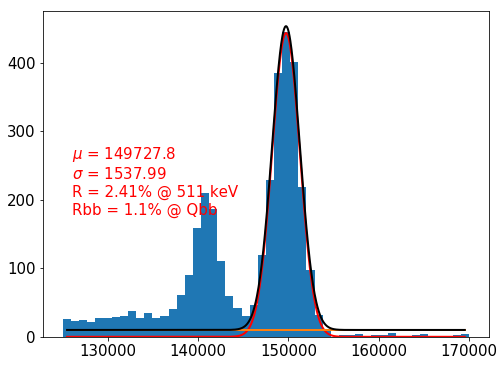

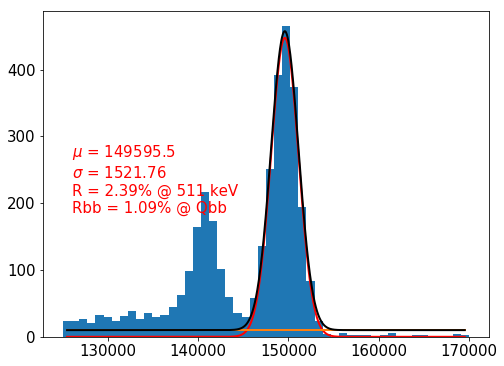

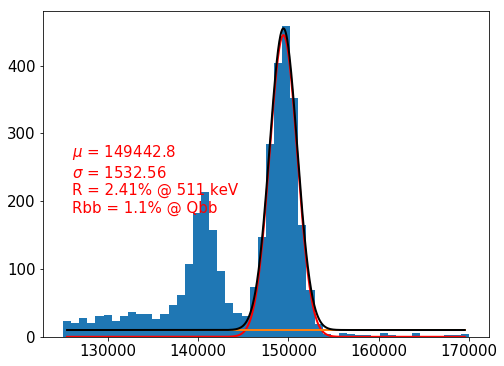

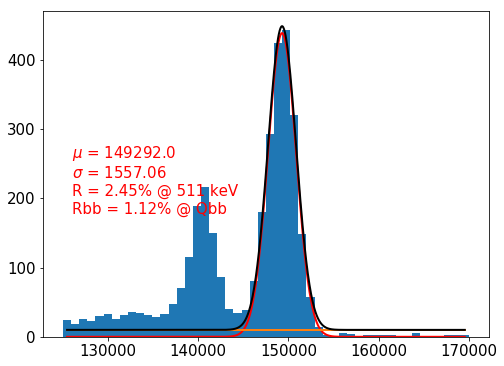

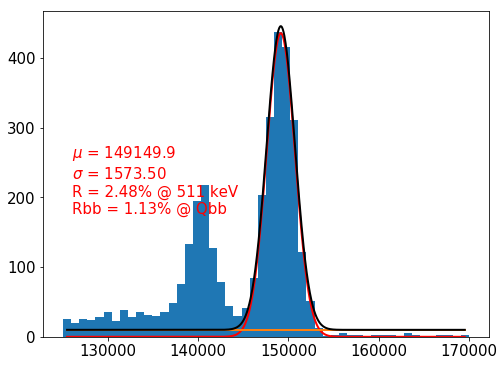

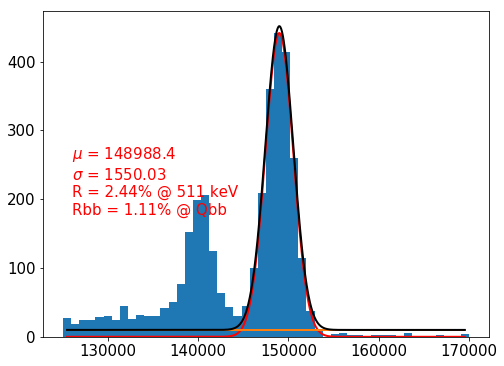

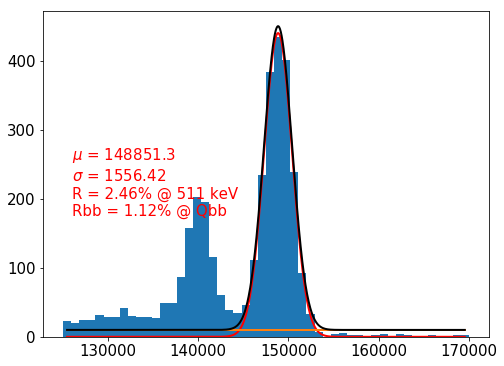

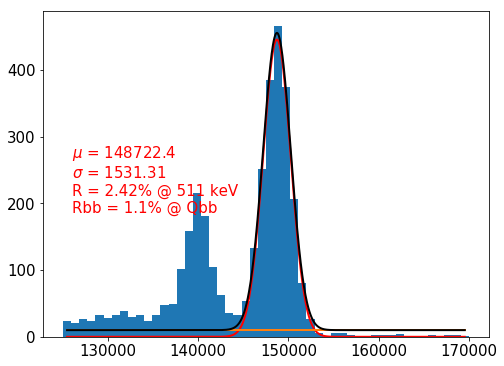

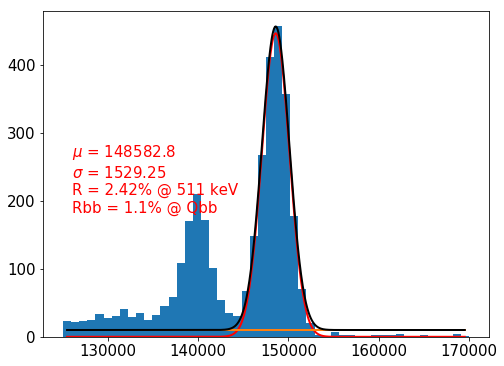

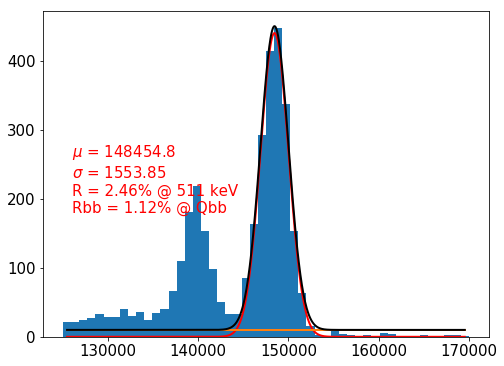

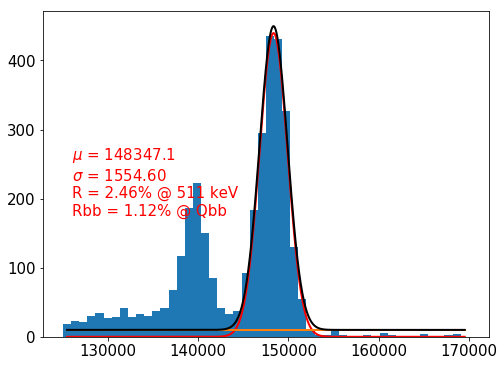

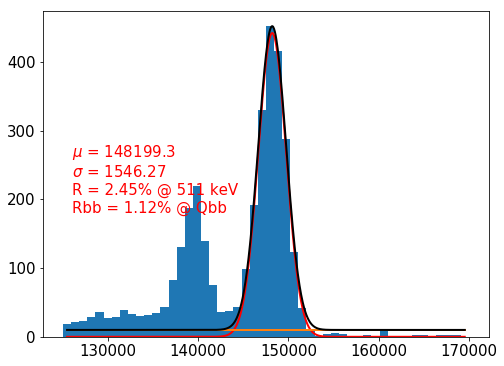

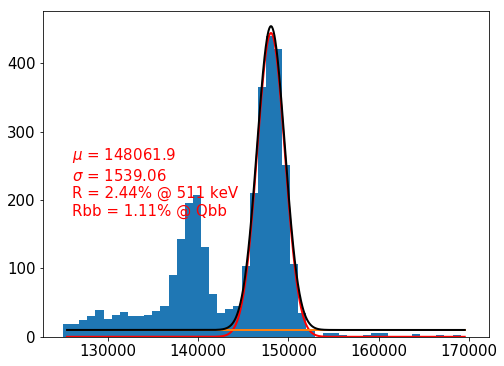

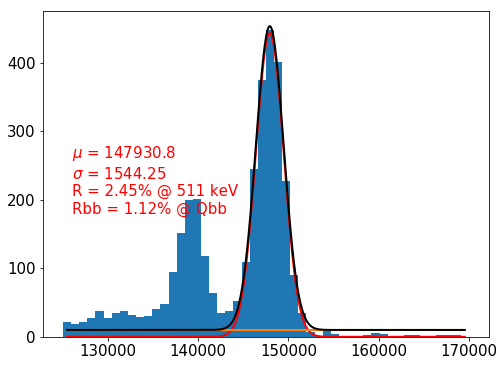

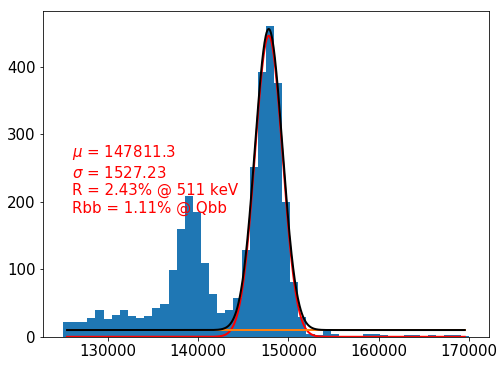

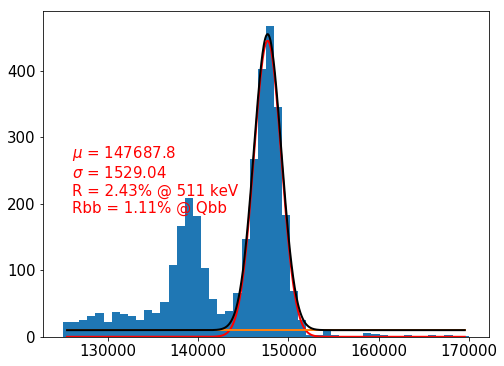

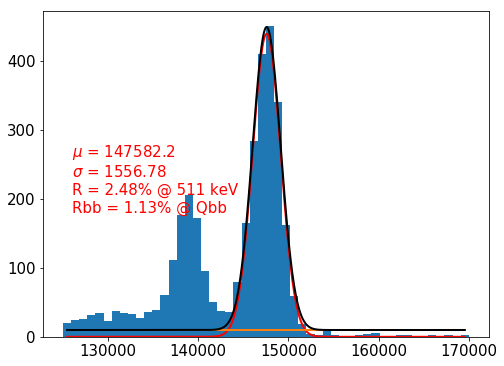

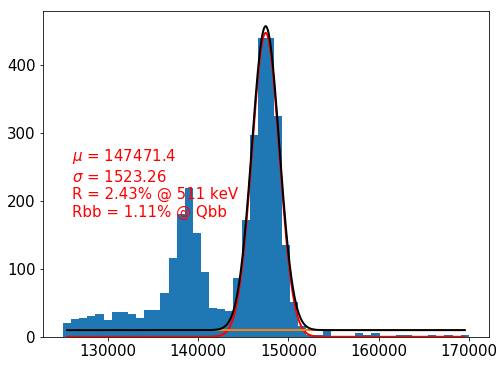

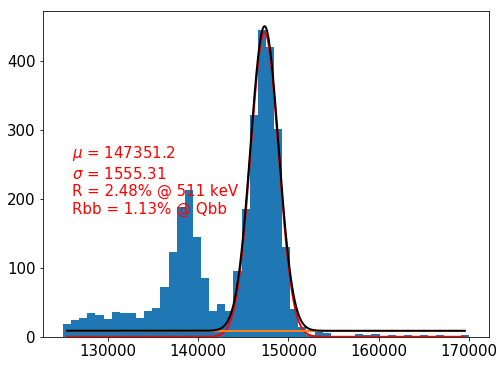

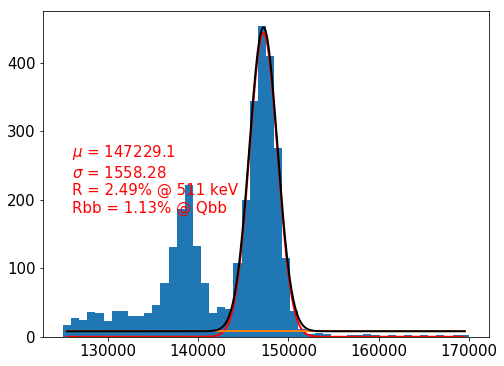

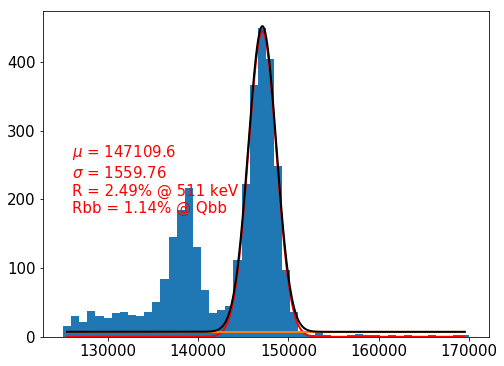

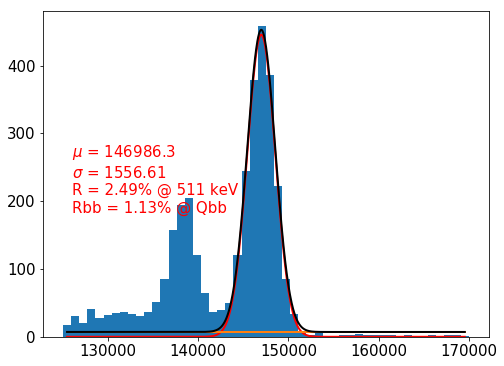

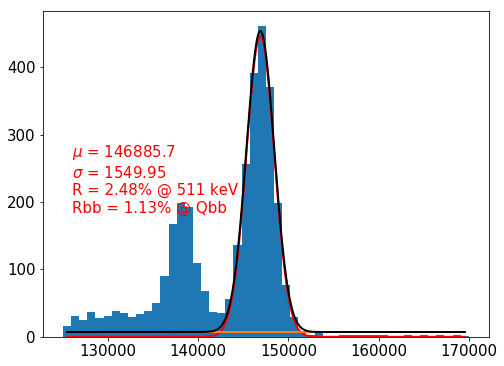

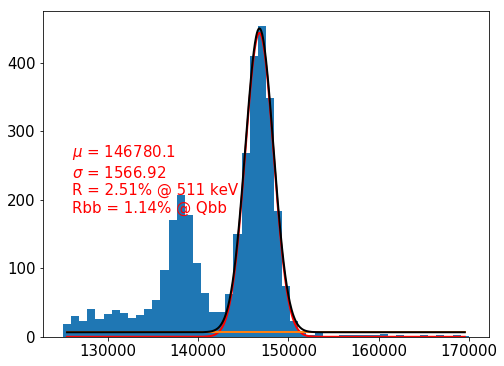

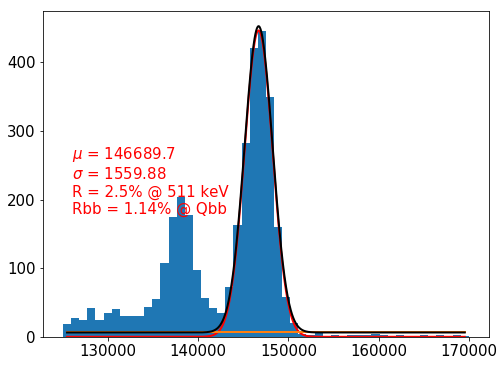

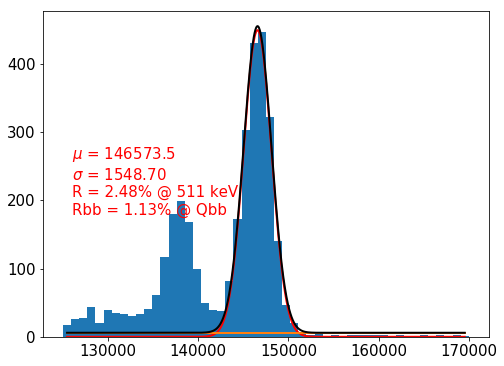

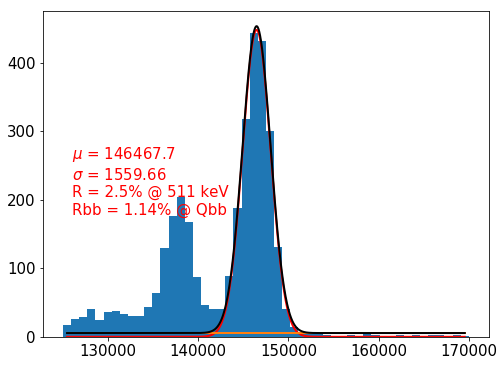

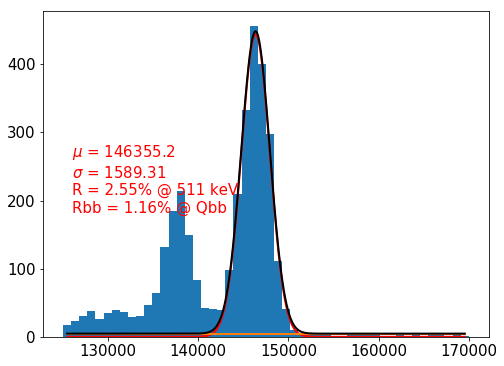

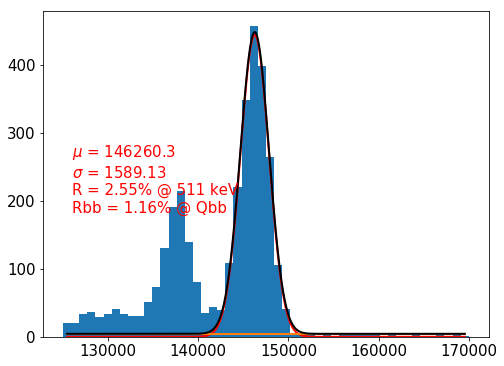

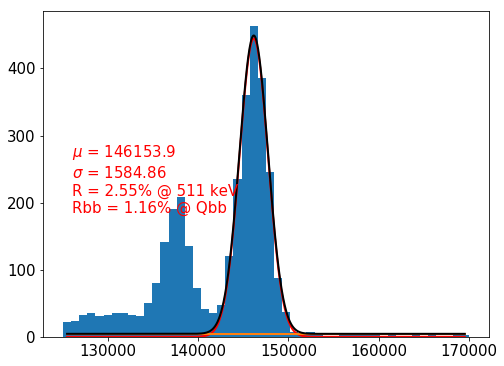

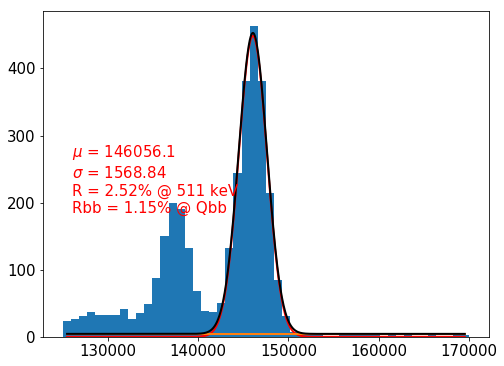

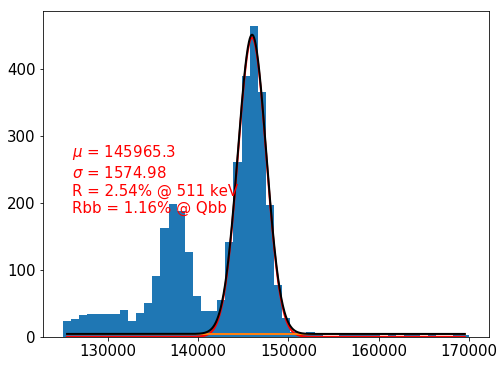

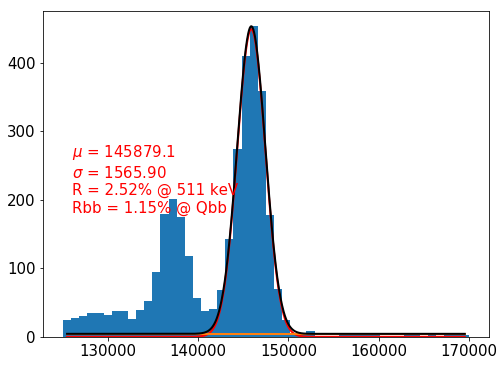

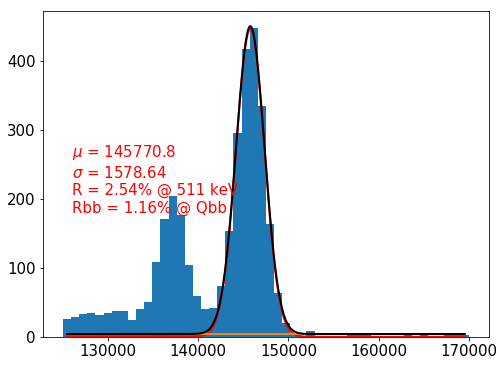

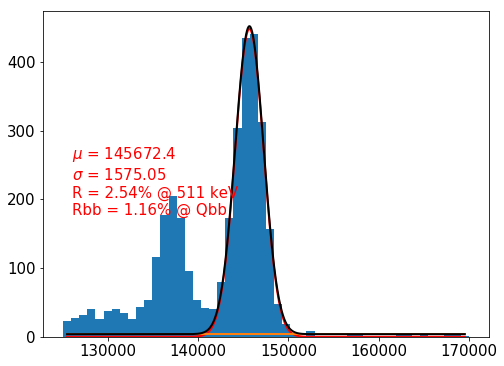

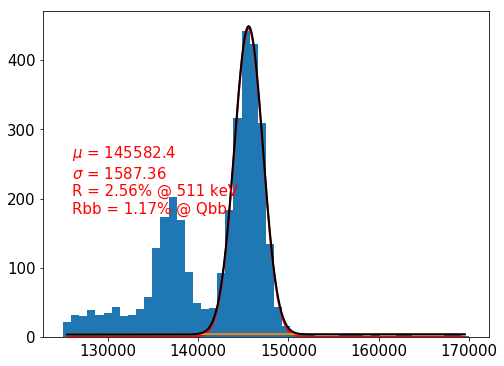

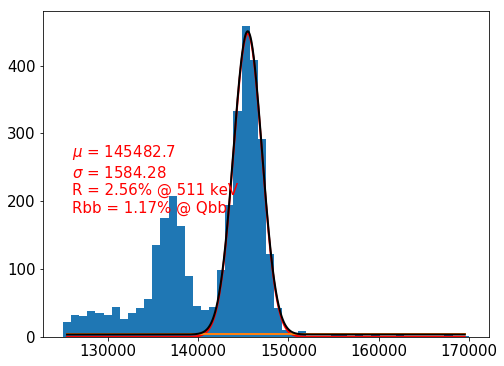

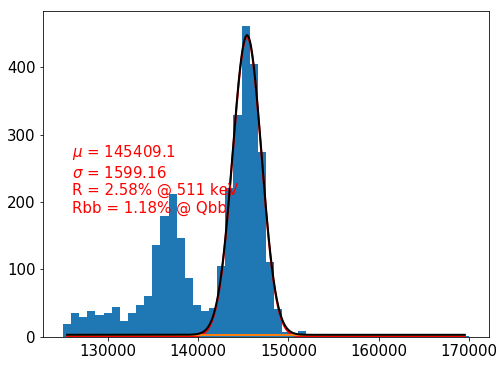

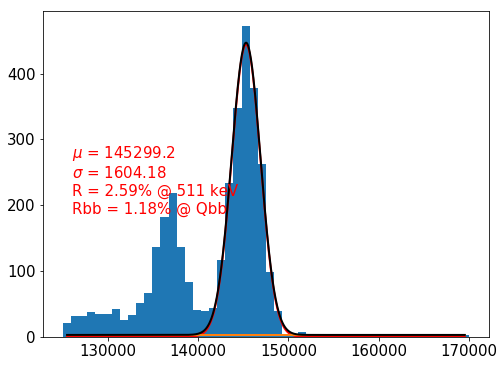

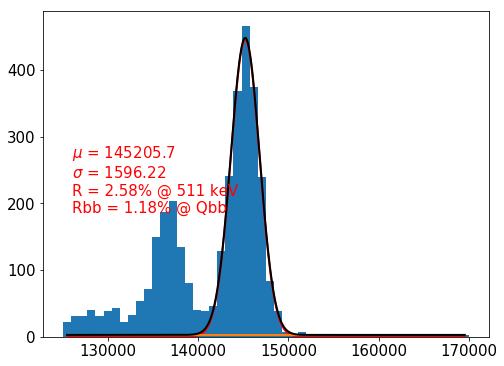

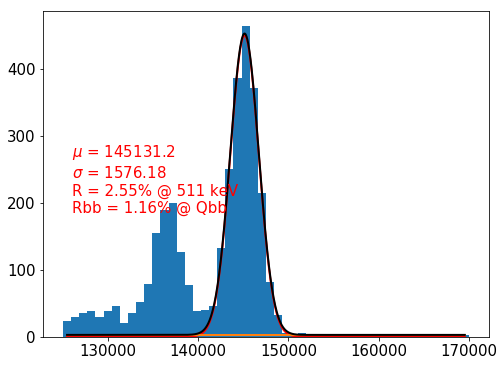

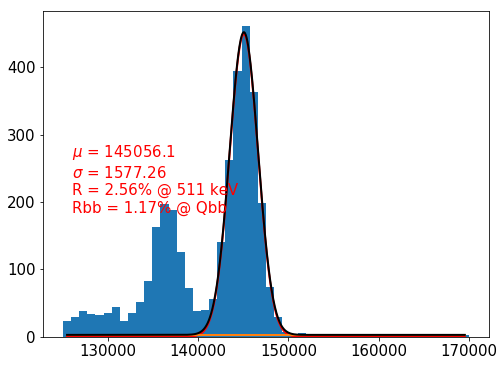

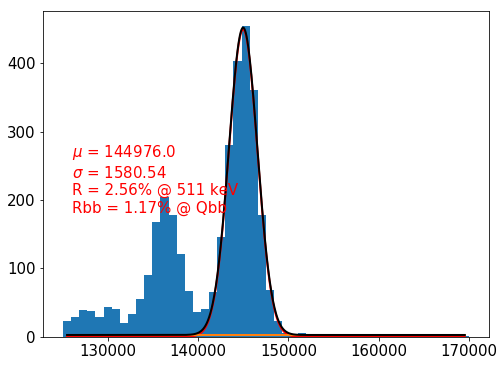

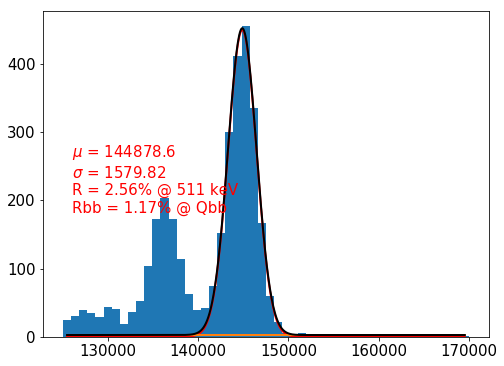

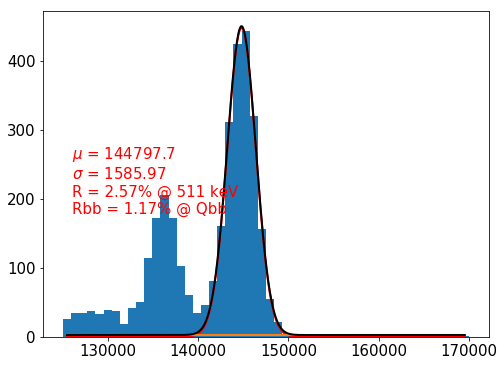

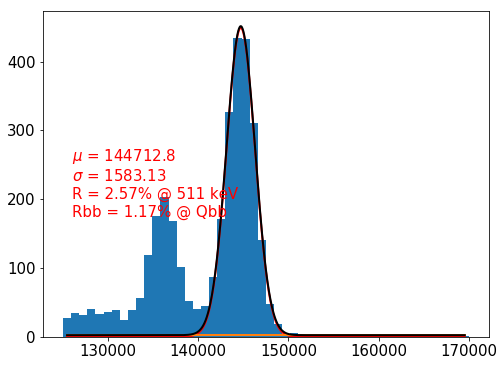

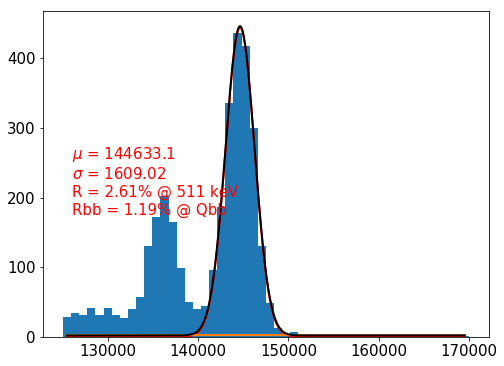

In [164]:
lf_base   = 1039
lf_err    = 31.5
nsigmas   = 10
npoints   = 100

lf_list   = lf_base - nsigmas*lf_err + np.linspace(0, 3*nsigmas*lf_err,npoints)
res_list2 = []

for lfi in lf_list:
    Zcorr_aux = corrf.LifetimeCorrection(lfi, lf_err)
    
    data = fid
    Efull_zcorr = data.S2e.values * Zcorr_aux(data.Z.values).value * xy_map(data.X.values,data.Y.values).value

    y, x, _ = hist(Efull_zcorr, 50, range=[1.25e5,1.7e5])

    seed =  1e4,   1.5e5, 1e3, 10
    low  =  1e4,  1.1e5,  10e2, 0 
    upp  =  1e8,     2e5, 5e5, 10
    f    = fitf.fit(one_gauss, x, y, seed, fit_range=(1.40e5,1.75e5), bounds=(low, upp))
    #print(f.values)
    #print(f.errors)


    xrange = np.linspace(x[0], x[-1],1000)


    plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
    #plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=2)
    plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
    plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)
    plt.text(1.25e5+1e3, 1*max(y)/3+30, gausstext(f.values, 511), color=fitOpt)
    
    res_list2.append(resolution(f.values,f.errors))
    

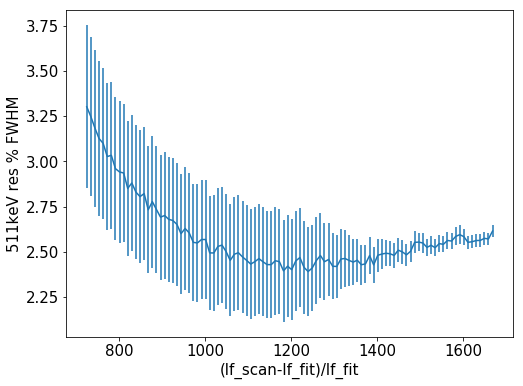

In [165]:
plt.errorbar(lf_list,[res_list2[i][0][0] for i in range(npoints)],[res_list2[i][0][1] for i in range(npoints)])
plt.xlabel('(lf_scan-lf_fit)/lf_fit')
plt.ylabel('511keV res % FWHM')

Energy at z=0 = 8726.0 +- 126.1
Lifetime      = 1244.5 +- 137.6
Chi2          = 2.32          
Energy at z=0 = 8854.6 +- 25.3
Lifetime      = 1210.1 +- 24.7
Chi2          = 0.12          
Energy at z=0 = 8864.2 +- 43.9
Lifetime      = 1115.6 +- 36.1
Chi2          = 0.27          
Energy at z=0 = 8592.4 +- 67.2
Lifetime      = 1093.7 +- 54.9
Chi2          = 0.68          
Energy at z=0 = 7831.6 +- 47.9
Lifetime      = 1187.7 +- 49.8
Chi2          = 0.42          
Energy at z=0 = 7368.1 +- 74.6
Lifetime      = 1007.2 +- 59.9
Chi2          = 1.21          


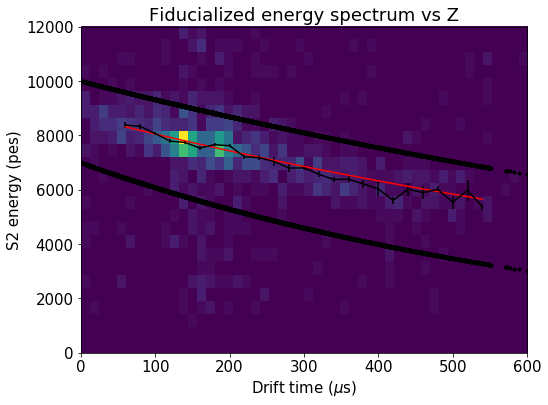

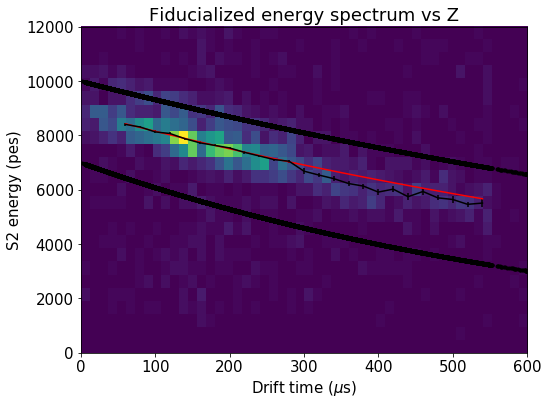

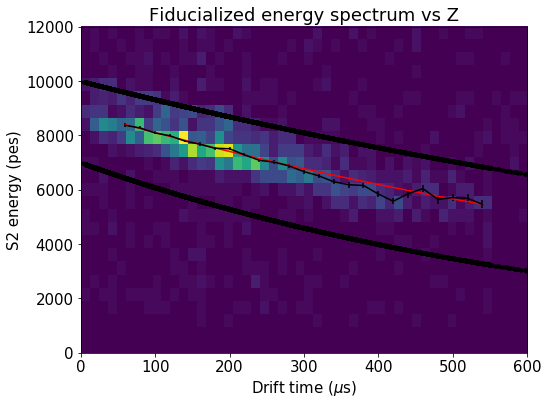

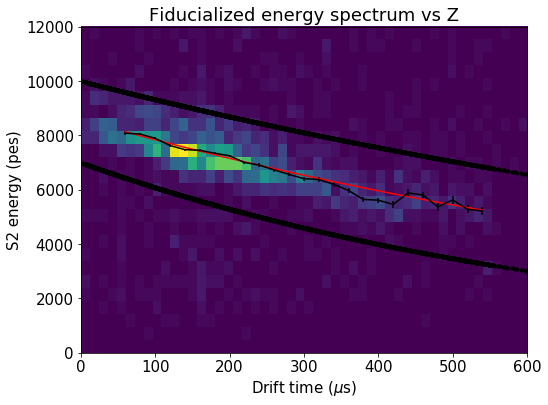

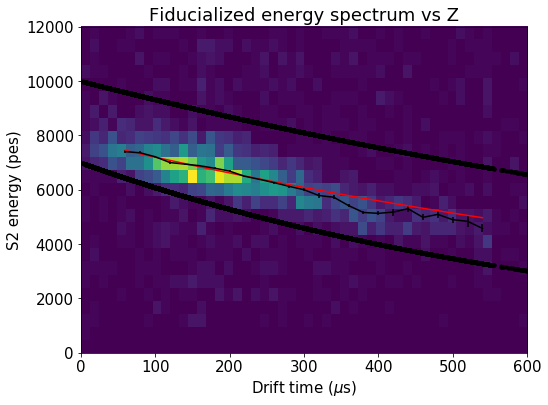

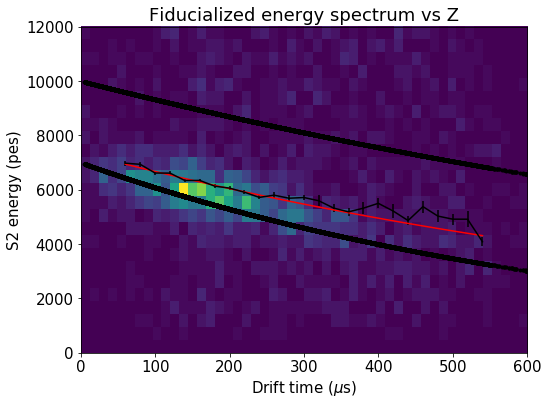

In [193]:
lf_base   = 1039
lf_err    = 31.5
nsigmas   = 10
npoints   = 100
Rlist     = [0,50,100,125,150,180,200]

res_listR = []

for i in range(len(Rlist)-1):
    data = full[fitf.in_range(full.R, Rlist[i], Rlist[i+1])]
    low_cut   =  7000 * np.exp(-0.0014*data.Z.values)
    high_cut  = 10000 * np.exp(-0.0007*data.Z.values)
    sel       = coref.in_range(data.S2e.values, low_cut, high_cut) # remove low and high E background

    hist2d(data.Z, data.S2e, (50, 25), range=(Zrange, [0,12e3]))
    x, y, u_y = fitf.profileX(data.Z[sel], data.S2e[sel], 25, xrange=(50,550), yrange=[0,12e3])

    plt.errorbar(x, y, yerr=u_y, fmt='k')#, profOpt)
    plt.plot(data.Z.values,  low_cut, "k.")
    plt.plot(data.Z.values, high_cut, "k.")

    seed = 9000,-981#np.max(y), (x[15] - x[5])/np.log(y[15]/y[5])
    f    = fitf.fit(fitf.expo, x, y, seed, fit_range=(50,300), sigma=u_y)

    plt.plot(x, f.fn(x), fitOpt)
    print("Energy at z=0 = {:.1f} +- {:.1f}".format( f.values[0], f.errors[0]))
    print("Lifetime      = {:.1f} +- {:.1f}".format(-f.values[1], f.errors[1]))
    print("Chi2          = {:.2f}          ".format(f.chi2))

    labels("Drift time ($\mu$s)", "S2 energy (pes)", "Fiducialized energy spectrum vs Z")
    save("S2energyvsZ_fiducial")

    
    res_listR.append((f.values,f.errors))
    

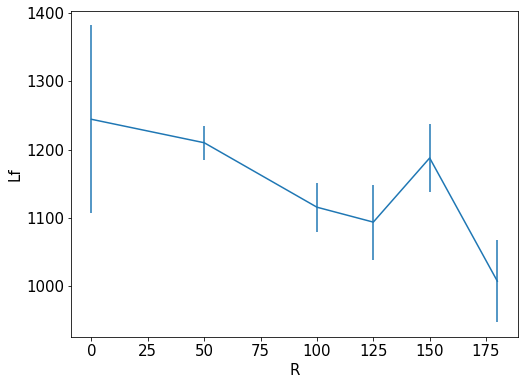

In [194]:
plt.errorbar(Rlist[:-1],[-res_listR[i][0][1] for i in range(len(Rlist)-1)],[res_listR[i][1][1] for i in range(len(Rlist)-1)])
plt.xlabel('R')
plt.ylabel('Lf')

In [188]:
[res_listR[i][0][0] for i in range(len(Rlist))]

IndexError: list index out of range

In [174]:
res_listR[0][0][1]

-1145.9577832918187